In [1]:
import mlflow
import os
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np

/Users/matthiasherp/anaconda3/envs/mctm_pytorch/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


### Demo on how to analyse MLFlow Stored Experiments

1. Below we move to the root of the project where the mlruns folder is. There we can then call experiment wise run data. MLFlow allows us to look at tags, parameters as well as metrics in a pandas dataframe and hence create plots across runs. See minimal example below.

2. All Tags, Parameters, Metrics and Artifacts (Every Datatype, manely Plots and the Model) can also be viewed using the MLFlow User Interface which is a server you run locally. Simply open a new terminal and run "mlflow ui", then the server runs in that terminal and you can see it in the browser under "http://127.0.0.1:5000" (can be changed by a comand). Server can be closed by closing the terminal and running "pkill -f mlflow" in another terminal.

3. The only annoying thing about mlflow is that is uses absolute instead of relative paths. This means that if you want to analyze results created on another machine (server or another person) then it does not work. However I have coded a workaround that patches the paths. To solve this simply run the python script "/simulation_studies/mlflow_change_mlflow_artifact_directiories.py" in a terminal.


In [2]:
# move to project root directory to find the mlruns folder with mlflow experiments
notebook_path = Path().resolve()
project_root = notebook_path.parent  # adjust as needed
os.chdir(project_root)

In [3]:
experiment_name = "rine_5D_1000obs_bootstrap_hydra_fixed_copula_smaller_penlasso"
experiment = mlflow.get_experiment_by_name(experiment_name) 
df_runs = mlflow.search_runs([experiment.experiment_id])

# subset all runs seed smaller 32
df_runs = df_runs[df_runs["tags.seed_value"].astype(int) < 32]

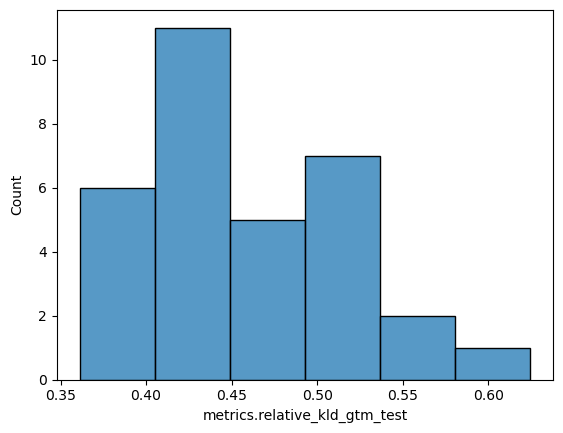

In [4]:
bootstrap_bool = df_runs["tags.mlflow.runName"].str.contains("bootstrap")
df_run_originals_only = df_runs[~bootstrap_bool]


sns.histplot(data=df_run_originals_only, x="metrics.relative_kld_gtm_test")
plt.show()

In [5]:
df_run_originals_only["metrics.relative_kld_gtm_test"].mean()

0.46040000000000003

In [6]:
df_run_originals_only["metrics.relative_kld_gtm_test"].quantile(0.5)

0.44035

In [7]:
cols = [
    "params.penalty_decorrelation_ridge_first_difference_chosen",
    "params.penalty_decorrelation_ridge_second_difference_chosen",
]

df_runs[cols] = df_runs[cols].astype(float)

(-5.0, 35.0)

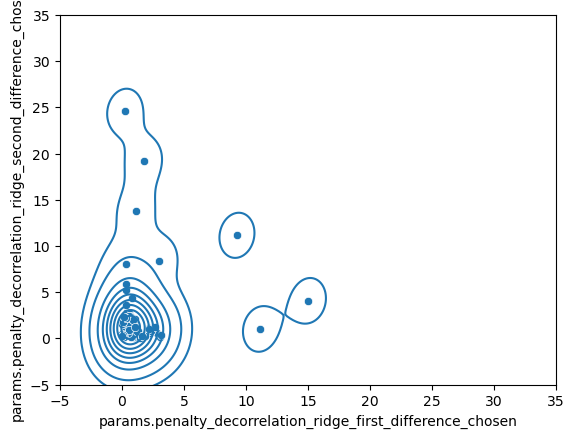

In [8]:
sns.kdeplot(data=df_runs, x="params.penalty_decorrelation_ridge_first_difference_chosen", y="params.penalty_decorrelation_ridge_second_difference_chosen")
sns.scatterplot(data=df_runs, x="params.penalty_decorrelation_ridge_first_difference_chosen", y="params.penalty_decorrelation_ridge_second_difference_chosen")
plt.ylim(-5,35)
plt.xlim(-5,35)

In [9]:
# load aritfact conditional_independence_table_data_validate.csv
#artifact_path = "conditional_independence_table_model_samples.csv"

# TEMPORARY: all seeds except 83 ad 48 as incomplete
#df_runs = df_runs[df_runs['tags.seed_value'] != str(83)]
#df_runs = df_runs[df_runs['tags.seed_value'] != str(48)]

N_train = df_runs['tags.N_train'].astype(int).iloc[0].item()
N_validate = df_runs['tags.N_validate'].astype(int).iloc[0].item()
N_train_proportion = N_train / (N_train + N_validate)
N_validate_proportion = N_validate / (N_train + N_validate)

table_diffs_list = []
table_original_dict = {}
for seed in df_runs['tags.seed_value'].unique():

    df_of_seed = df_runs[df_runs['tags.seed_value']==str(seed)]
    
    # TEMPORARY: for future bootstrap_warpspeed is a tag for now out of name
    bootstrap_bool = df_of_seed["tags.mlflow.runName"].str.contains("bootstrap")
    df_run_bootstrap = df_of_seed[bootstrap_bool]
    df_run_original = df_of_seed[~bootstrap_bool]

    # for train data and validate data
    #artifact_path = "conditional_independence_table_model_samples.csv" #"conditional_independence_table_data_train.csv"
    artifact_path = "conditional_independence_table_data_train.csv"
    table_bootstrap_train = pd.read_csv(mlflow.artifacts.download_artifacts(run_id=df_run_bootstrap['run_id'].item(), artifact_path=artifact_path))
    table_original_train = pd.read_csv(mlflow.artifacts.download_artifacts(run_id=df_run_original['run_id'].item(), artifact_path=artifact_path))
    #artifact_path = "conditional_independence_table_model_samples.csv" #"conditional_independence_table_data_validate.csv"
    artifact_path = "conditional_independence_table_data_validate.csv"
    table_bootstrap_validate = pd.read_csv(mlflow.artifacts.download_artifacts(run_id=df_run_bootstrap['run_id'].item(), artifact_path=artifact_path))
    table_original_validate = pd.read_csv(mlflow.artifacts.download_artifacts(run_id=df_run_original['run_id'].item(), artifact_path=artifact_path))
    
    # weight results together so its same data as used for training with GTM
    table_original = table_original_train.copy()
    table_bootstrap = table_bootstrap_train.copy()
    
    table_original.iloc[:, :3] = table_original_train.iloc[:, :3] * N_train_proportion + table_original_validate.iloc[:, :3] * N_validate_proportion
    table_bootstrap.iloc[:, :3] = table_bootstrap_train.iloc[:, :3] * N_train_proportion + table_bootstrap_validate.iloc[:, :3] * N_validate_proportion
    
    # check same ordering of var_row and var_col
    table_original.sort_values(by=['var_row', 'var_col'], inplace=True)
    table_bootstrap.sort_values(by=['var_row', 'var_col'], inplace=True)

    # check columns same:
    if table_original["var_col"].equals(table_bootstrap["var_col"]) and table_original["var_row"].equals(table_bootstrap["var_row"]):
        pass
    else:
        raise ValueError("var_row and var_col do not match between original and bootstrap tables")
    
    
    # compute difference in tables for all except first 3 columns
    table_diff = table_original.copy()
    table_diff.iloc[:, 3:] = table_original.iloc[:, 3:] - table_bootstrap.iloc[:, 3:]
    
    # across all seeds store the differences table in a joint array
    table_diffs_list.append(table_diff)
    table_original_dict[seed] = table_original
    
    

/var/folders/57/_f_fv4s97k300zslnyj86dxc0000gn/T/ipykernel_76074/1711349709.py:38: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0     5.0
1    10.0
2    11.0
3    15.0
4    16.0
5    17.0
6    20.0
7    21.0
8    22.0
9    23.0
Name: index, dtype: float64' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  table_original.iloc[:, :3] = table_original_train.iloc[:, :3] * N_train_proportion + table_original_validate.iloc[:, :3] * N_validate_proportion
/var/folders/57/_f_fv4s97k300zslnyj86dxc0000gn/T/ipykernel_76074/1711349709.py:38: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0    1.0
1    2.0
2    2.0
3    3.0
4    3.0
5    3.0
6    4.0
7    4.0
8    4.0
9    4.0
Name: var_row, dtype: float64' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  table_original.iloc[:, :3

In [10]:
metric =  "kld" #kld iae cond_correlation_abs_mean

In [11]:
dict_diffs = {}
for pair in zip(table_original['var_row'], table_original['var_col']):
    varrow = pair[0]
    varcol = pair[1]
    diffs_to_plot = []
    for table_diffs in table_diffs_list:
        diffs_value = table_diffs[(table_diffs['var_col'] == varcol) & (table_diffs['var_row'] == varrow)][metric].values[0]
        diffs_to_plot.append(diffs_value)
        
    dict_diffs[f"{int(varrow)}-{int(varcol)}"] = diffs_to_plot

In [12]:
counter = 0
for seed in df_runs['tags.seed_value'].unique():
    artifact_path = "conditional_independence_table_model_samples.csv" 
    table_bootstrap_train = pd.read_csv(mlflow.artifacts.download_artifacts(run_id=df_run_bootstrap['run_id'].item(), artifact_path=artifact_path))

    table_bootstrap_train[["var_row","var_col","dependence"]]
    table_bootstrap.sort_values(by=['var_row', 'var_col'], inplace=True)
    if counter == 0:
        counter += 1
        pass
    else:
        if all(table_bootstrap_train["dependence"] == table_bootstrap_train_prior["dependence"]):
            pass
        else:
             raise ValueError("dependence results differ between seeds")
    table_bootstrap_train_prior = table_bootstrap_train.copy()

In [13]:
from simulation_studies.generate_synthetic_vine_data import generate_synthetic_vine_data

/Users/matthiasherp/anaconda3/envs/mctm_pytorch/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


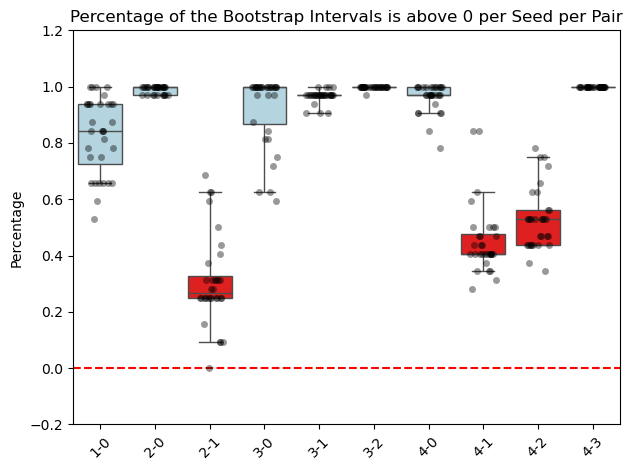

In [14]:
# for each seed plot boxplot of differences around orginal kld

list_percentage_ci_above_0 = []
for seed in df_runs['tags.seed_value'].unique():
    table_original = table_original_dict[seed]

    # add vector to the 
    centered_data = pd.DataFrame(dict_diffs) + np.array(table_original[metric])
    
    percentage_ci_above_0 = (centered_data > 0).mean(0)
    
    list_percentage_ci_above_0.append(percentage_ci_above_0)

df_percentage_ci_above_0 = pd.DataFrame(list_percentage_ci_above_0)

# --- Boxplot with 90% interval (whis=[5, 95]) ---
sns.boxplot(data=df_percentage_ci_above_0, whis=[5, 95], showfliers=False, palette=['lightblue','lightblue','red','lightblue','lightblue',
                                                                             'lightblue','lightblue','red','red','lightblue'])
# Colors on independence from above
sns.stripplot(data=df_percentage_ci_above_0, color='black', alpha=0.4, dodge=True, jitter=0.25)

plt.ylim(-0.2,1.2)
plt.axhline(0, color='red', linestyle='--')
plt.ylabel("Percentage")
plt.title("Percentage of the Bootstrap Intervals is above 0 per Seed per Pair")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

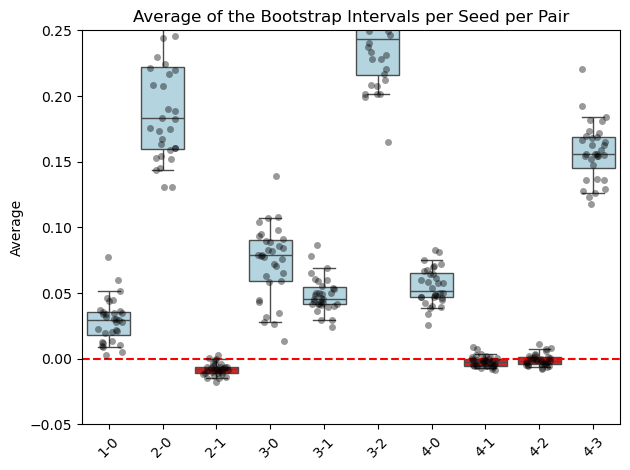

In [15]:
# for each seed plot boxplot of differences around orginal kld

list_average_ci = []
for seed in df_runs['tags.seed_value'].unique():
    table_original = table_original_dict[seed]

    # add vector to the 
    centered_data = pd.DataFrame(dict_diffs) + np.array(table_original[metric])
    
    average_ci = centered_data.mean(0)

    list_average_ci.append(average_ci)

df_average_ci = pd.DataFrame(list_average_ci)
# --- Boxplot with 90% interval (whis=[5, 95]) ---
sns.boxplot(data=df_average_ci, whis=[5, 95], showfliers=False, palette=['lightblue','lightblue','red','lightblue','lightblue',
                                                                             'lightblue','lightblue','red','red','lightblue'])
# Colors on independence from above
sns.stripplot(data=df_average_ci, color='black', alpha=0.4, dodge=True, jitter=0.25)

plt.ylim(-0.05,0.25)
plt.axhline(0, color='red', linestyle='--')
plt.ylabel("Average")
plt.title("Average of the Bootstrap Intervals per Seed per Pair")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

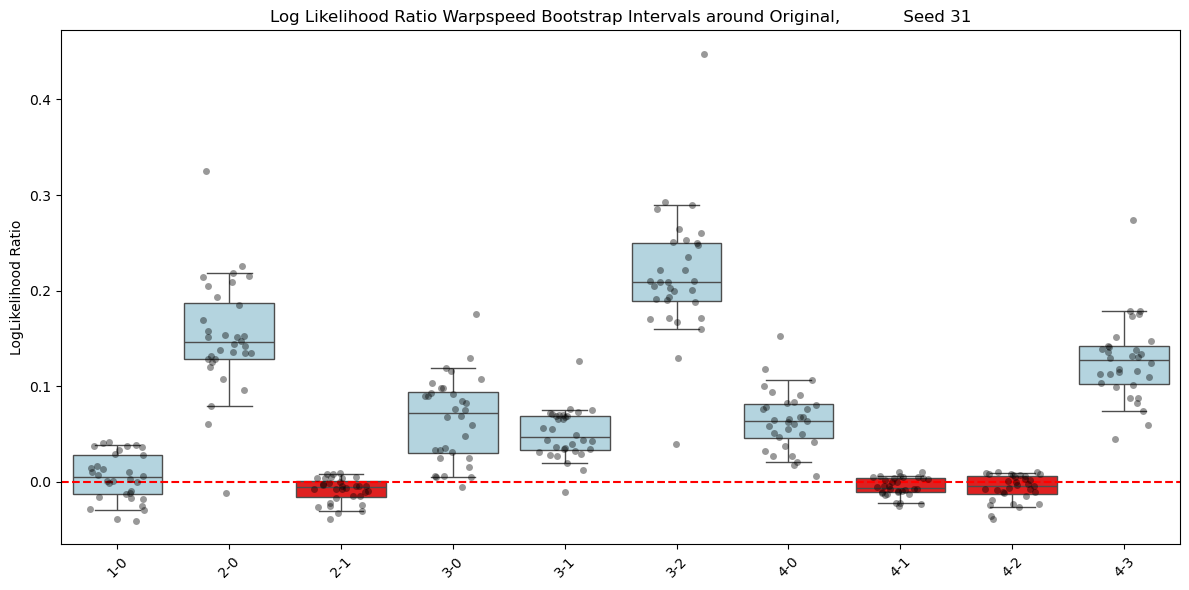

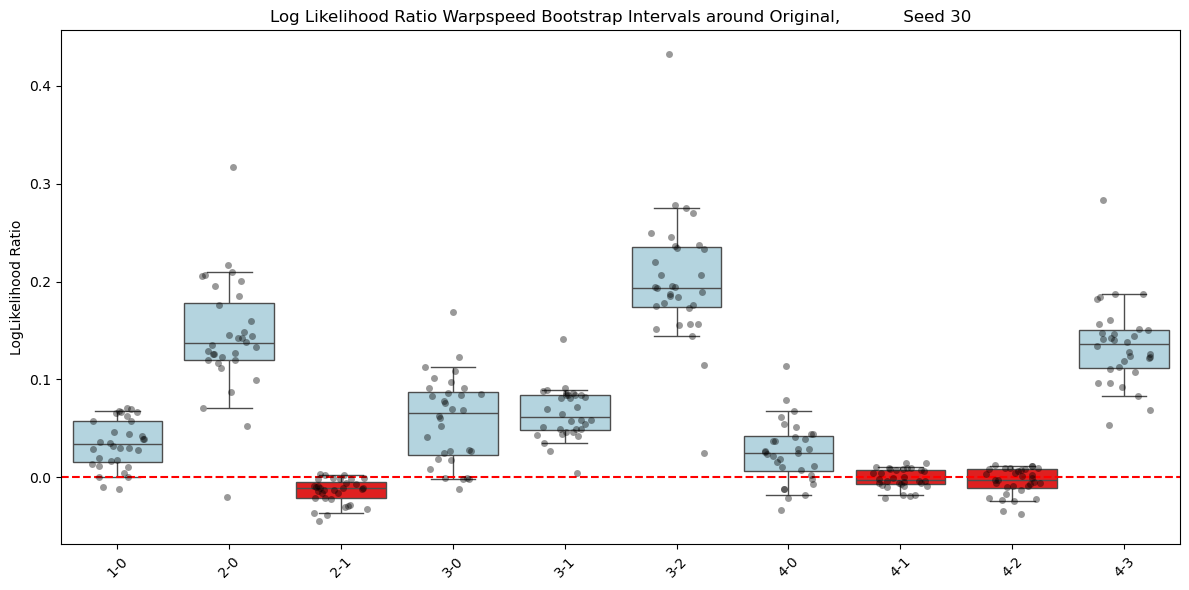

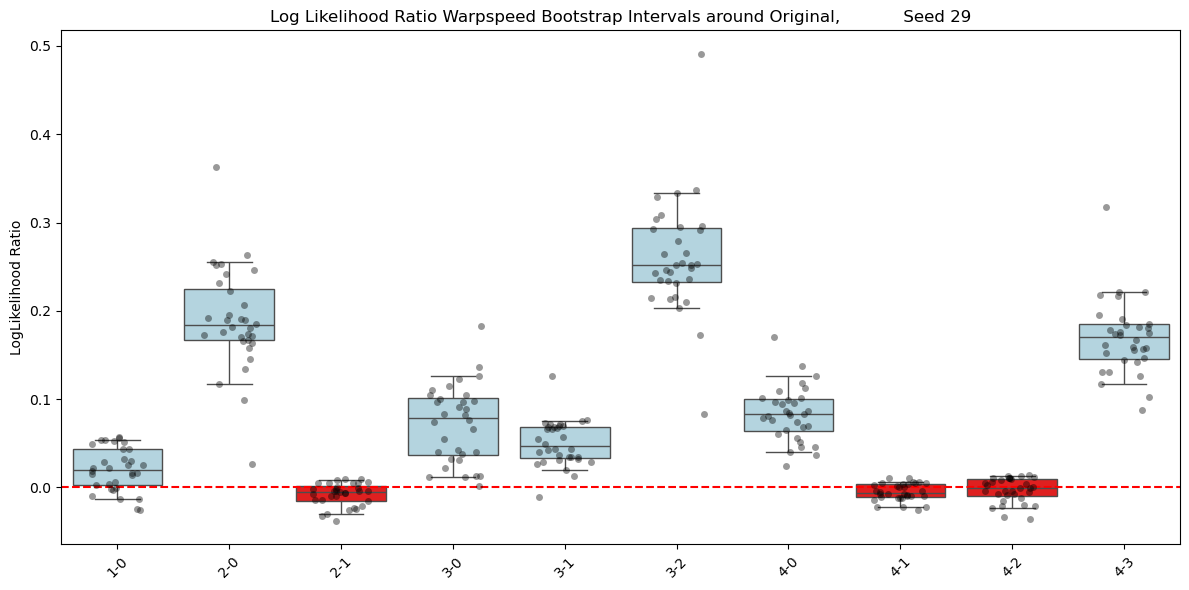

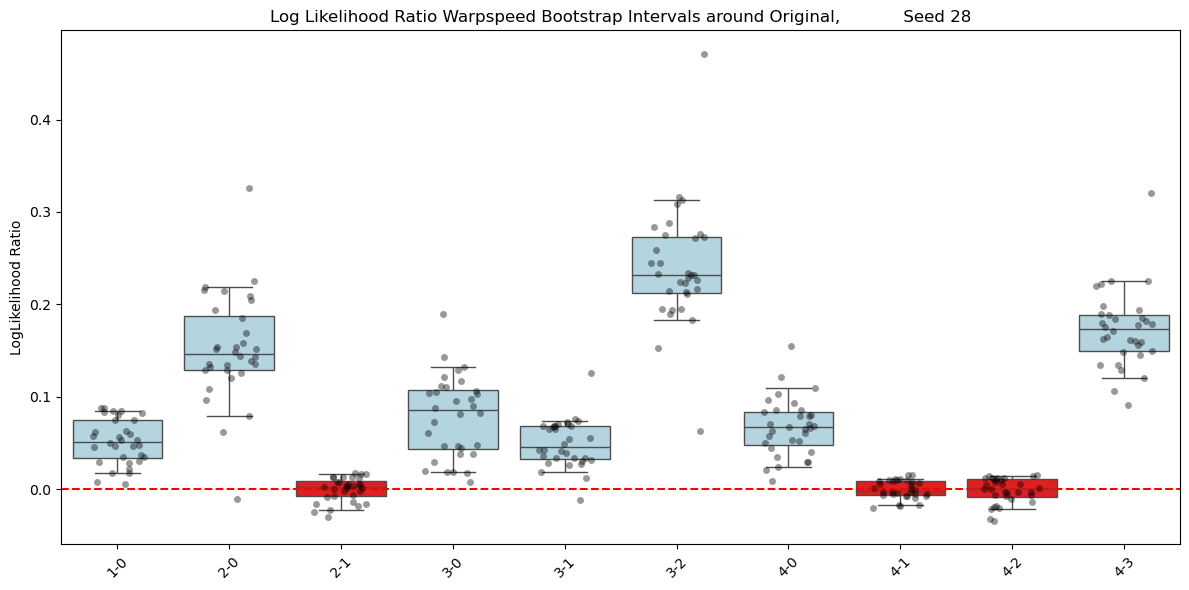

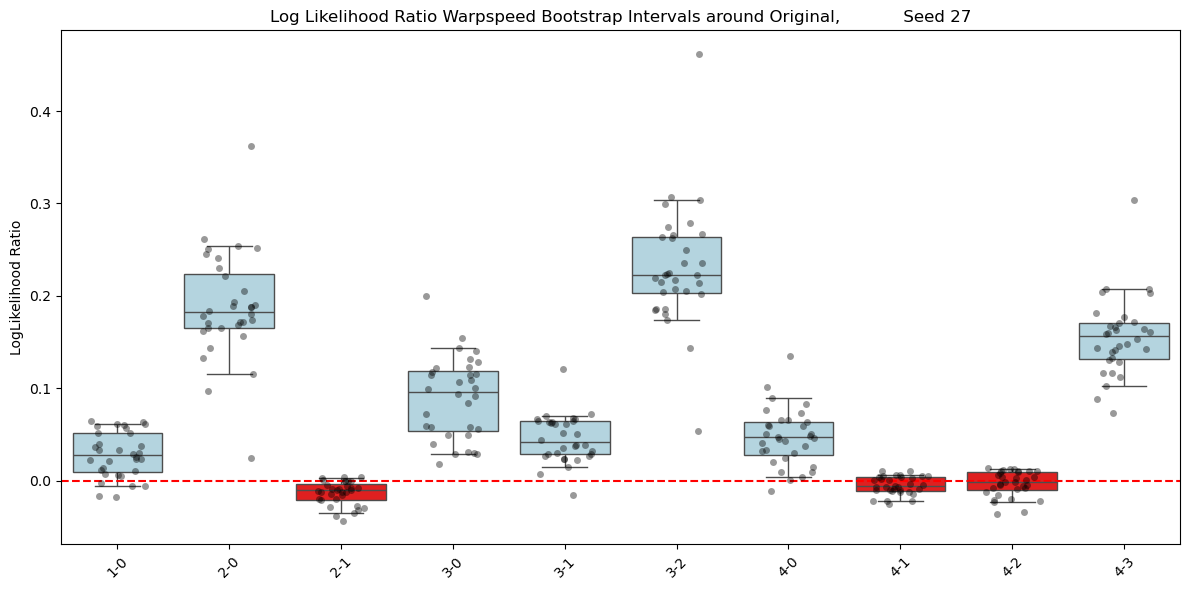

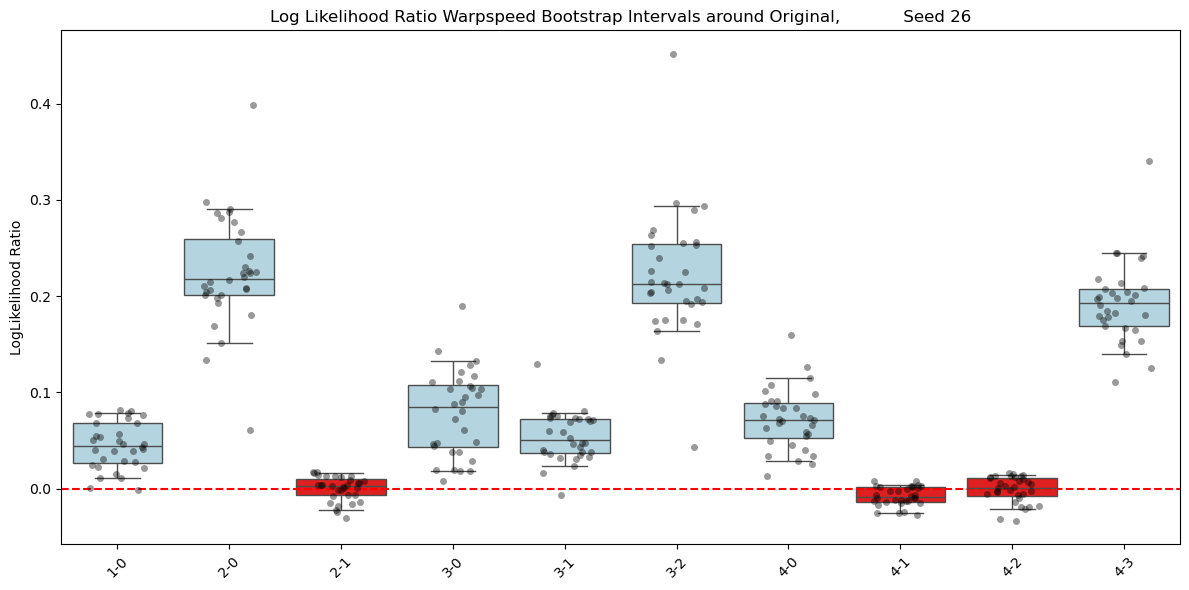

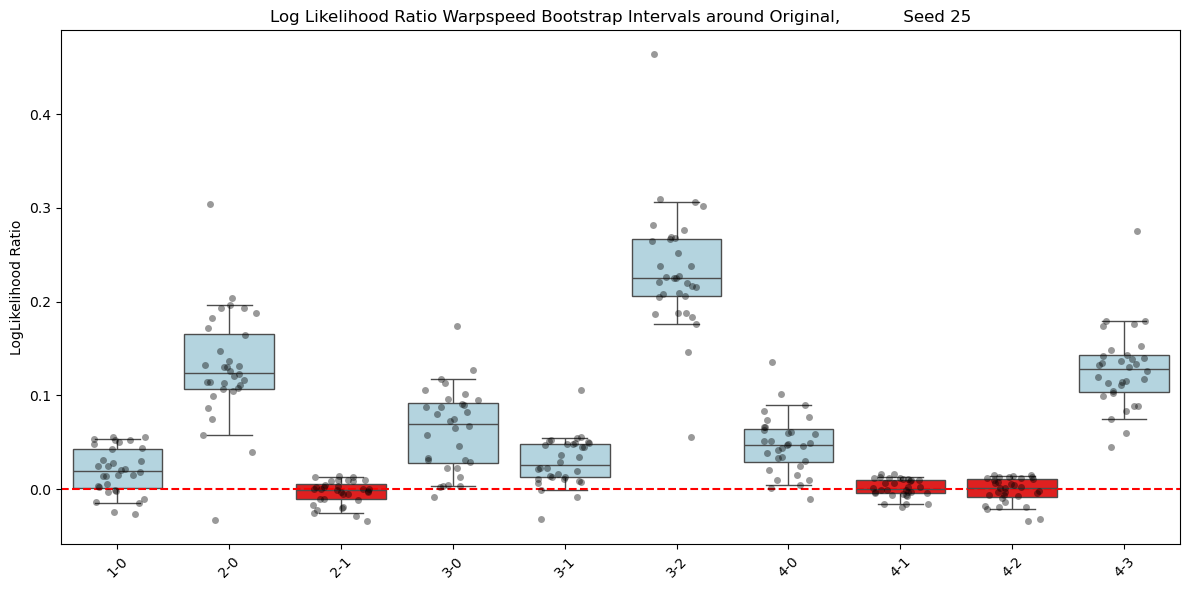

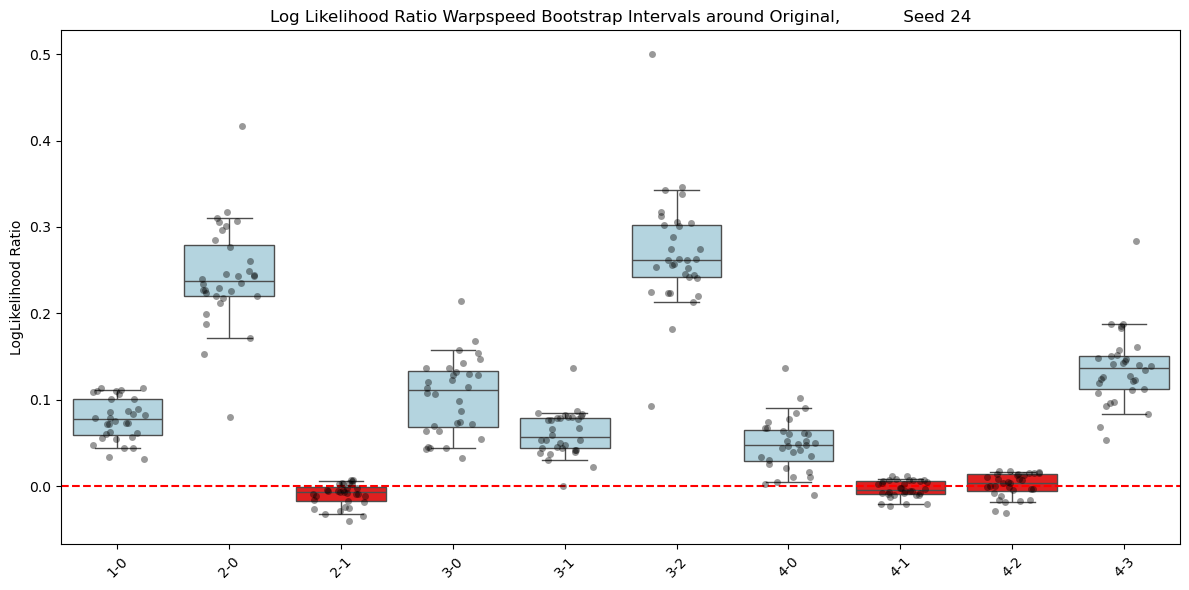

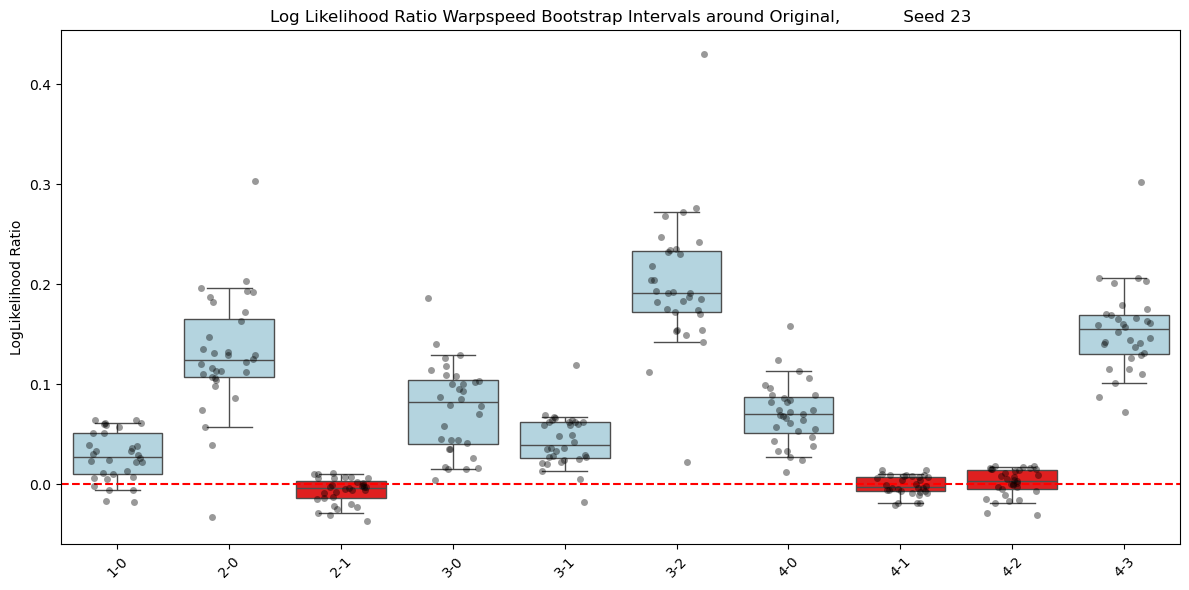

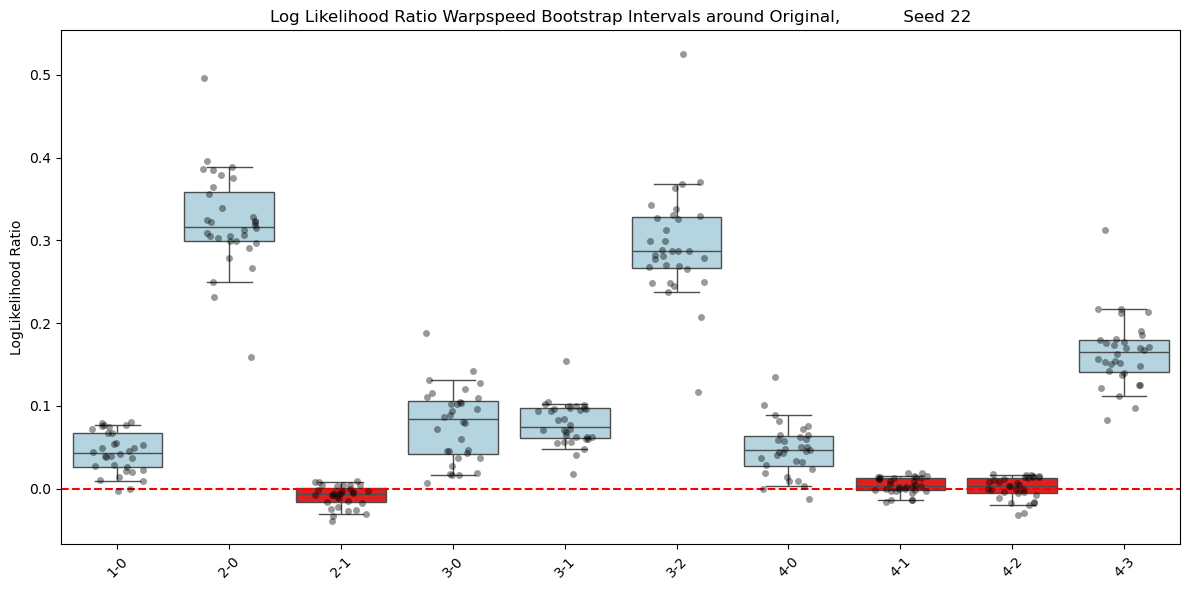

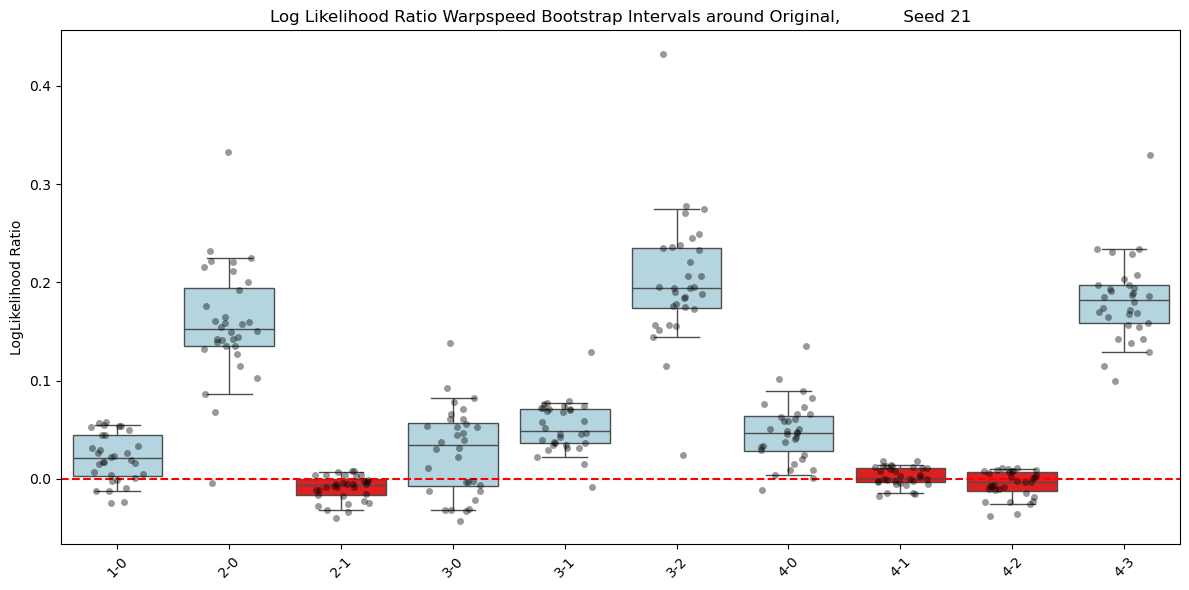

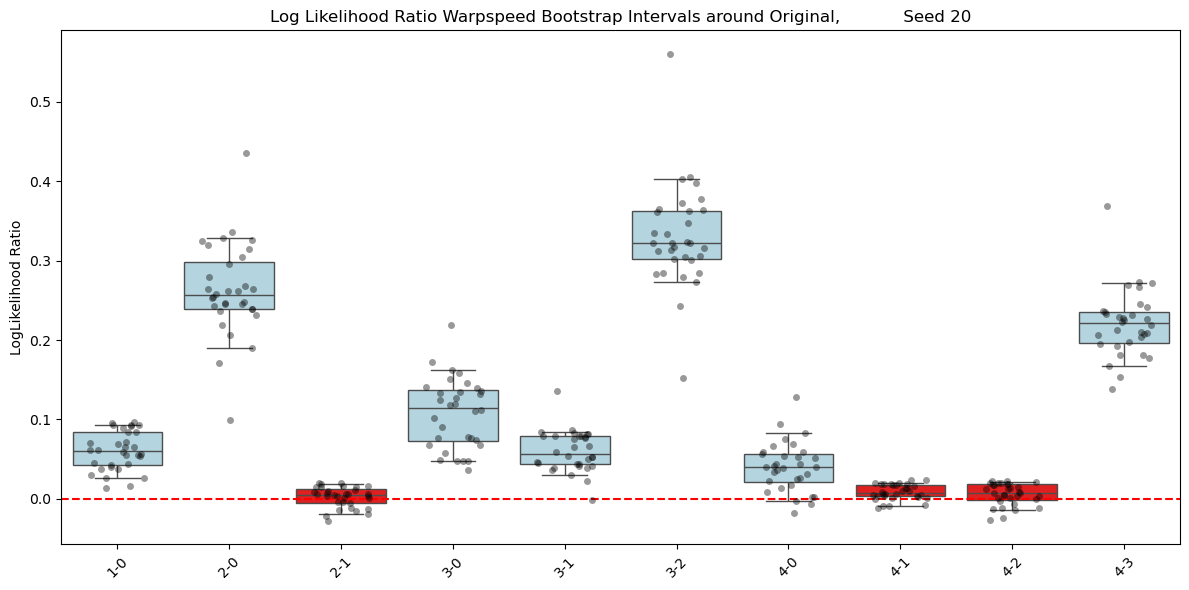

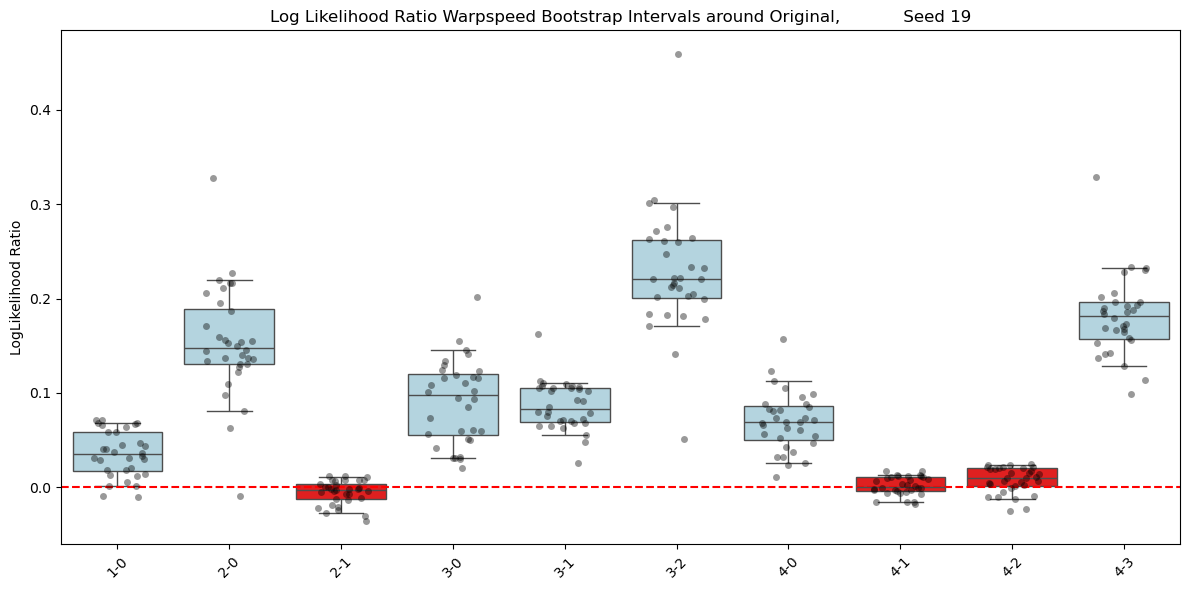

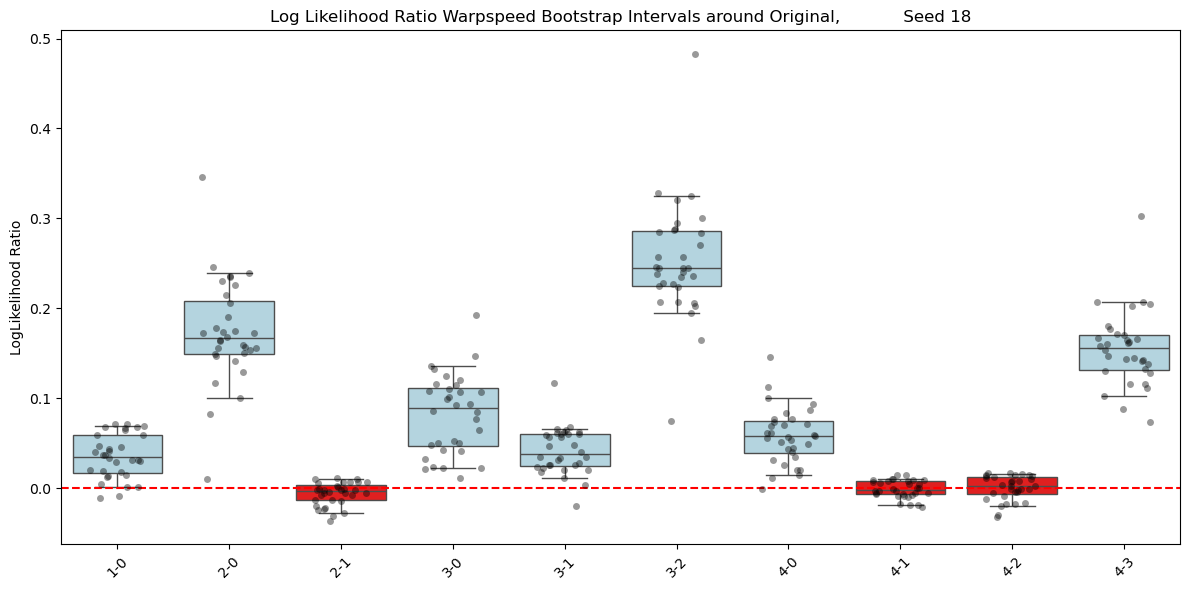

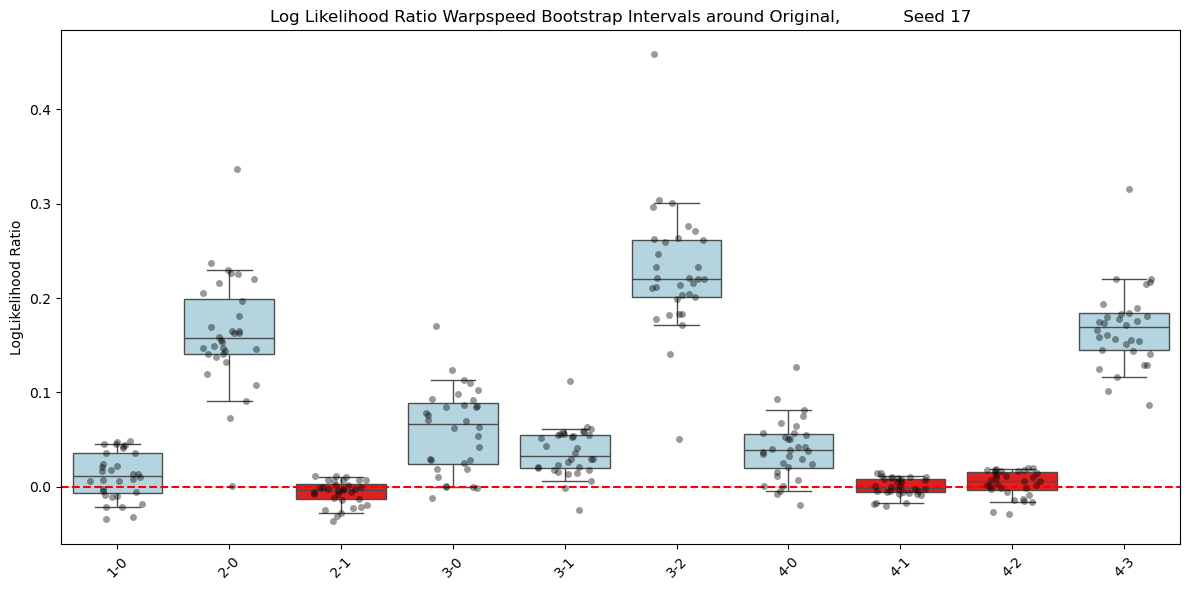

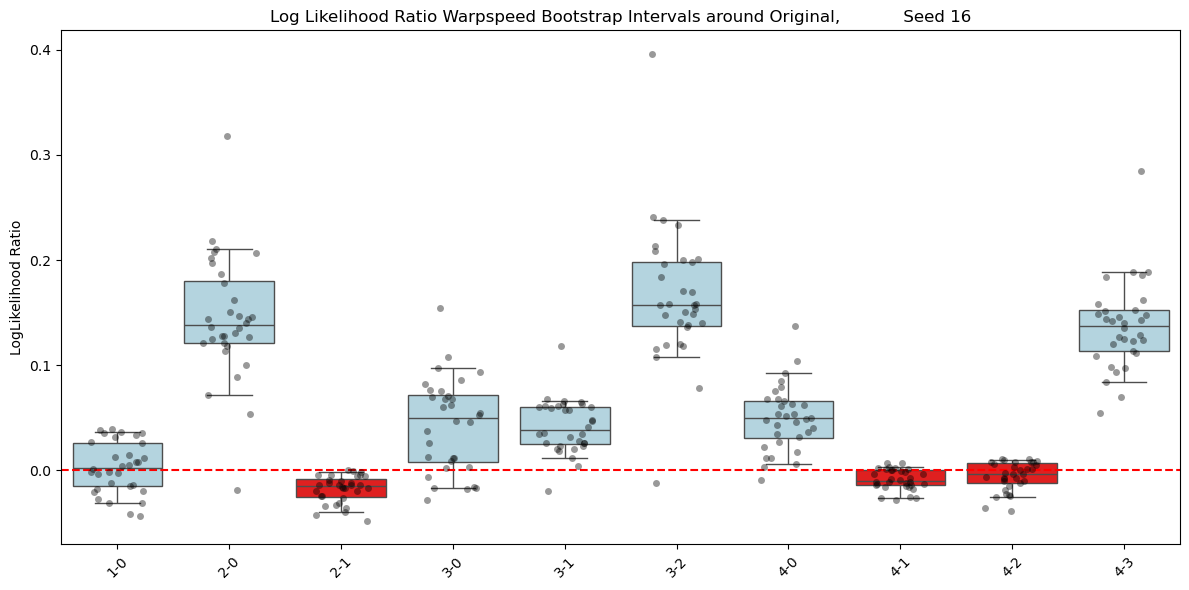

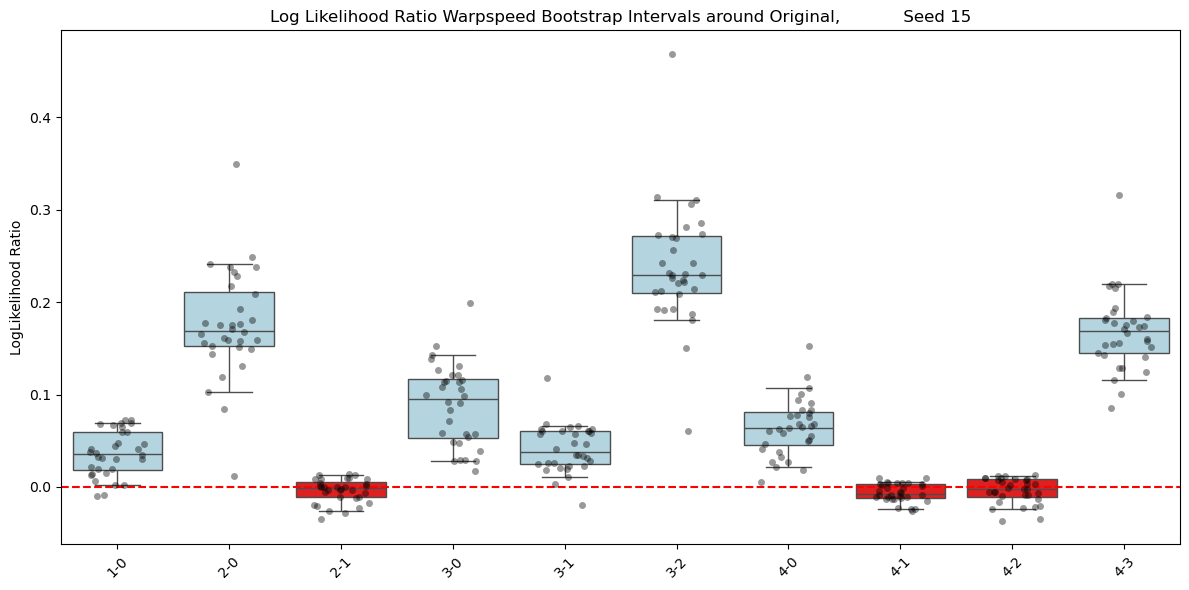

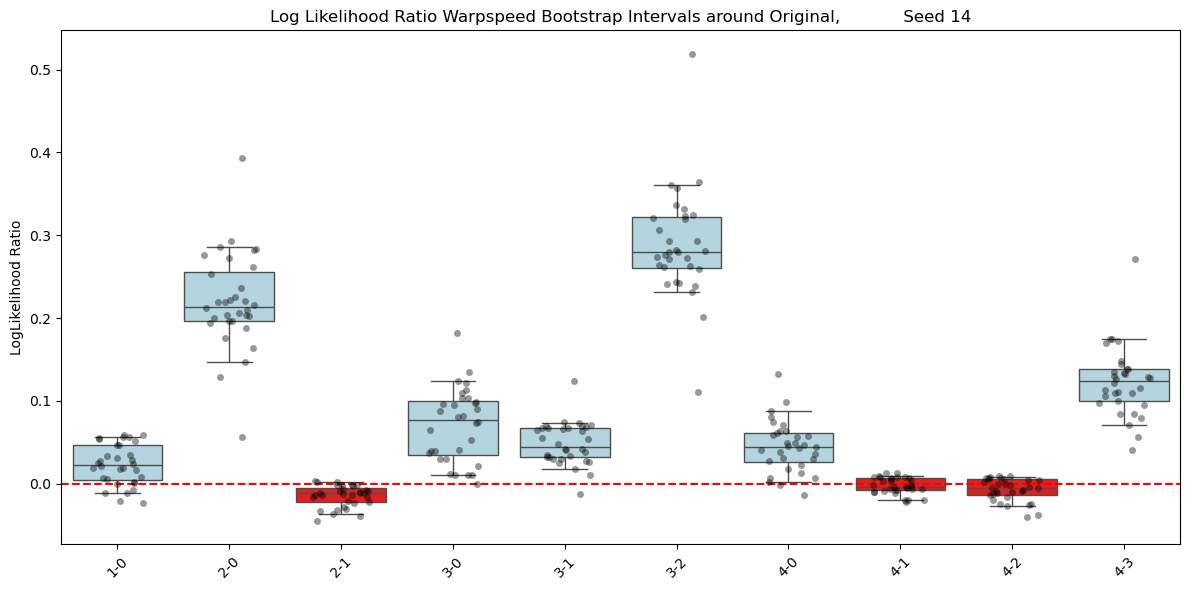

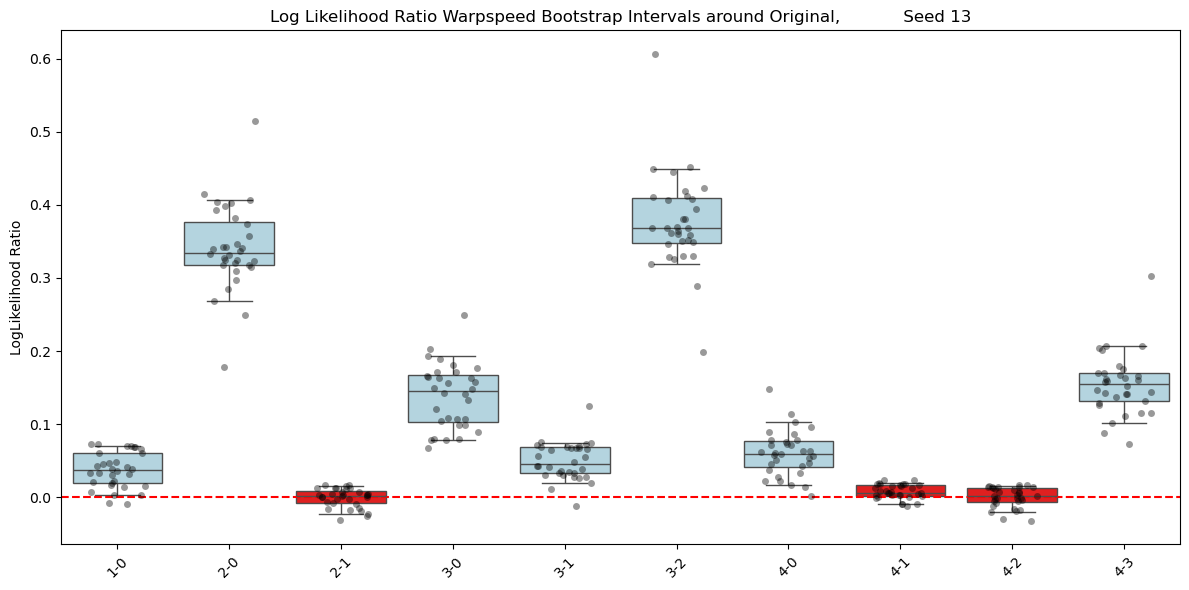

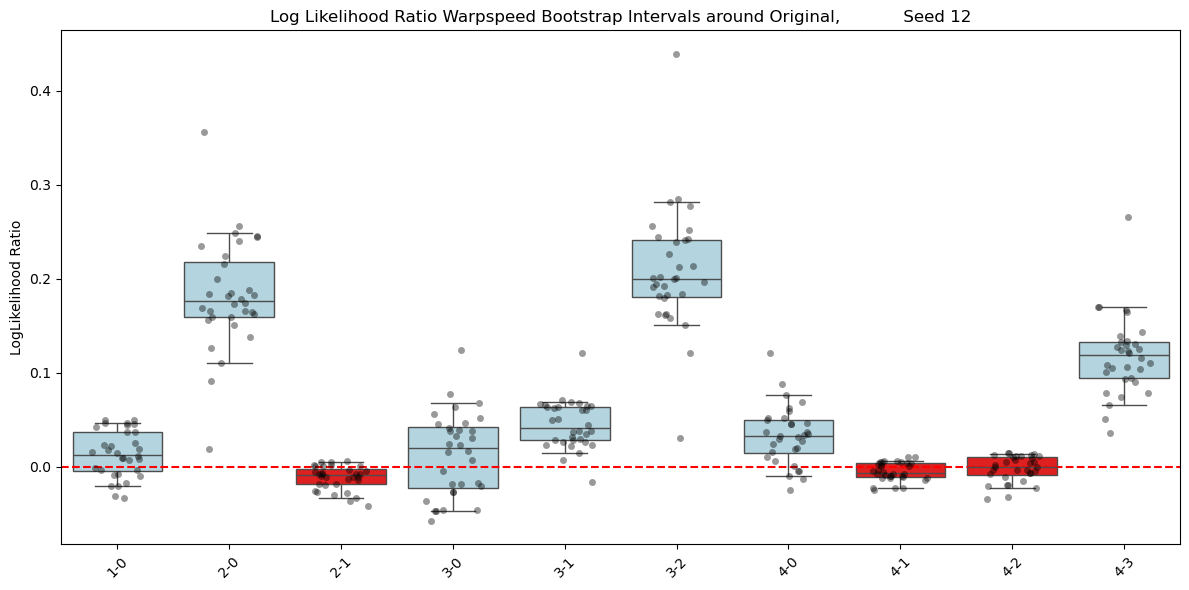

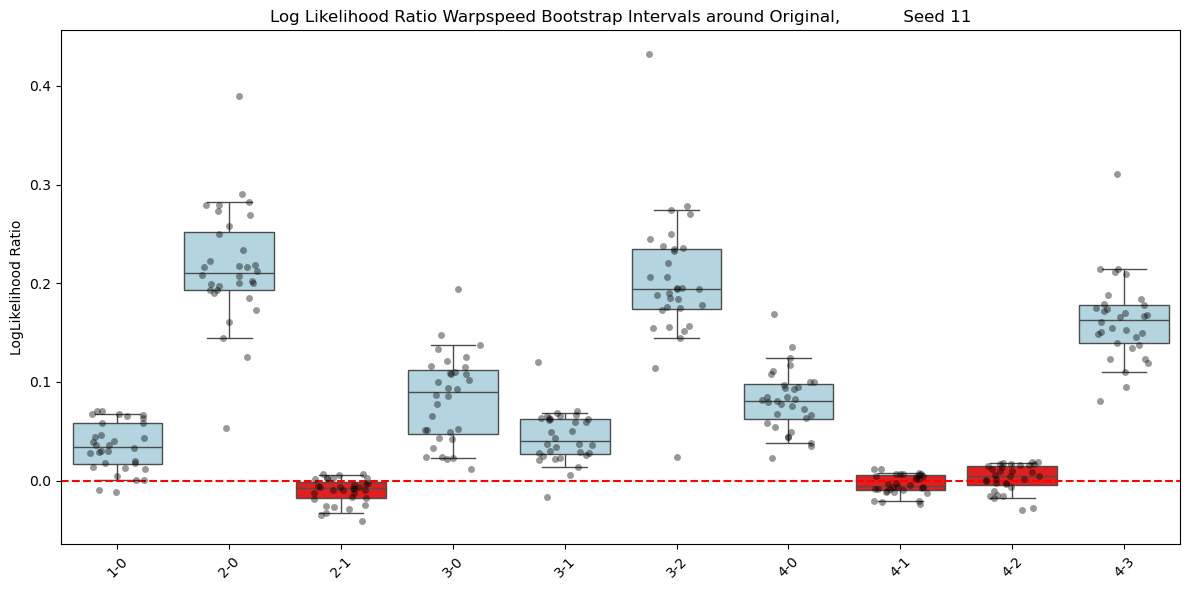

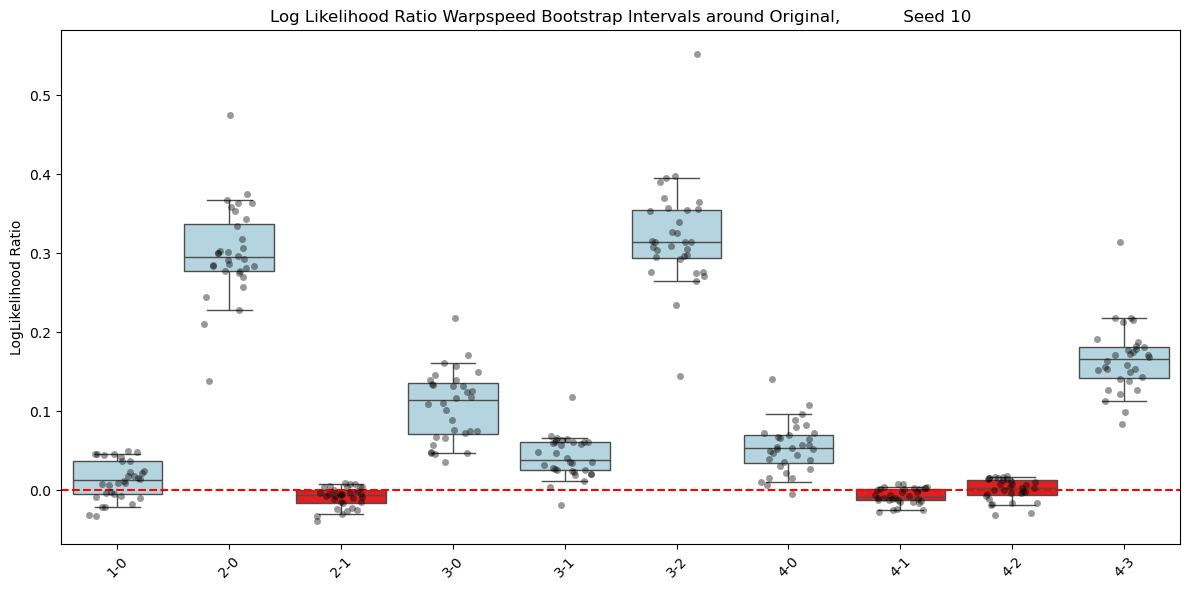

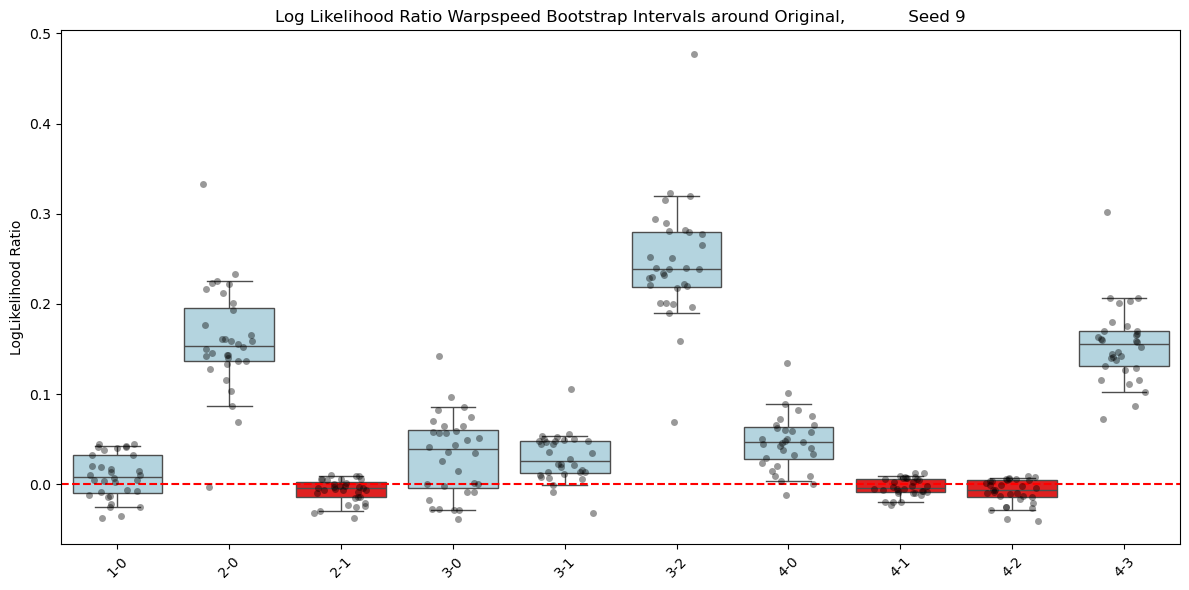

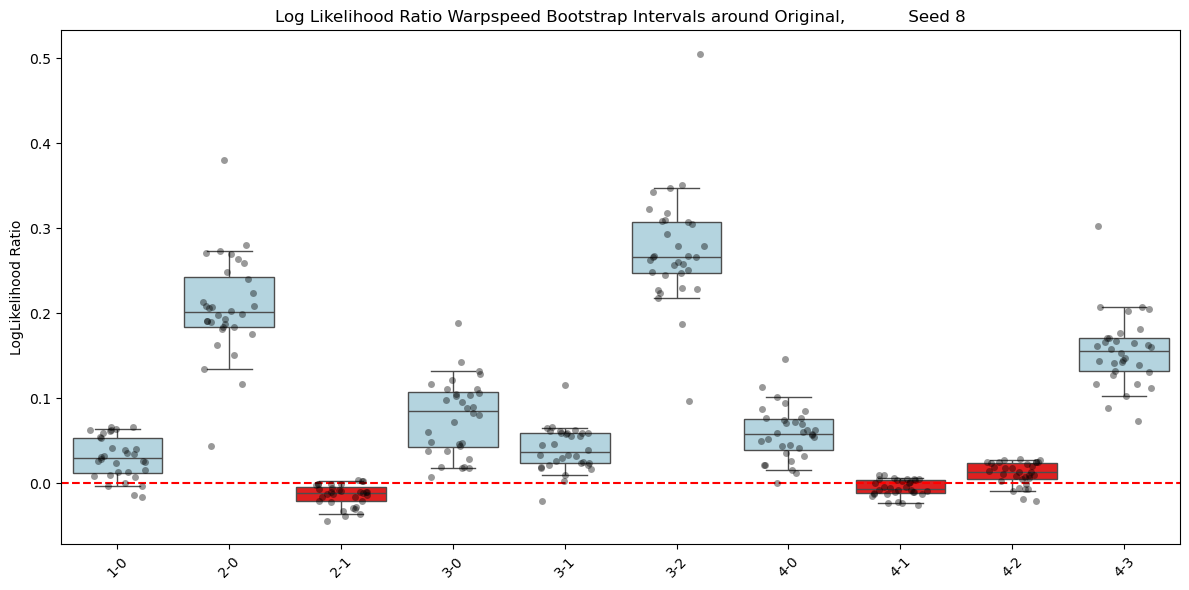

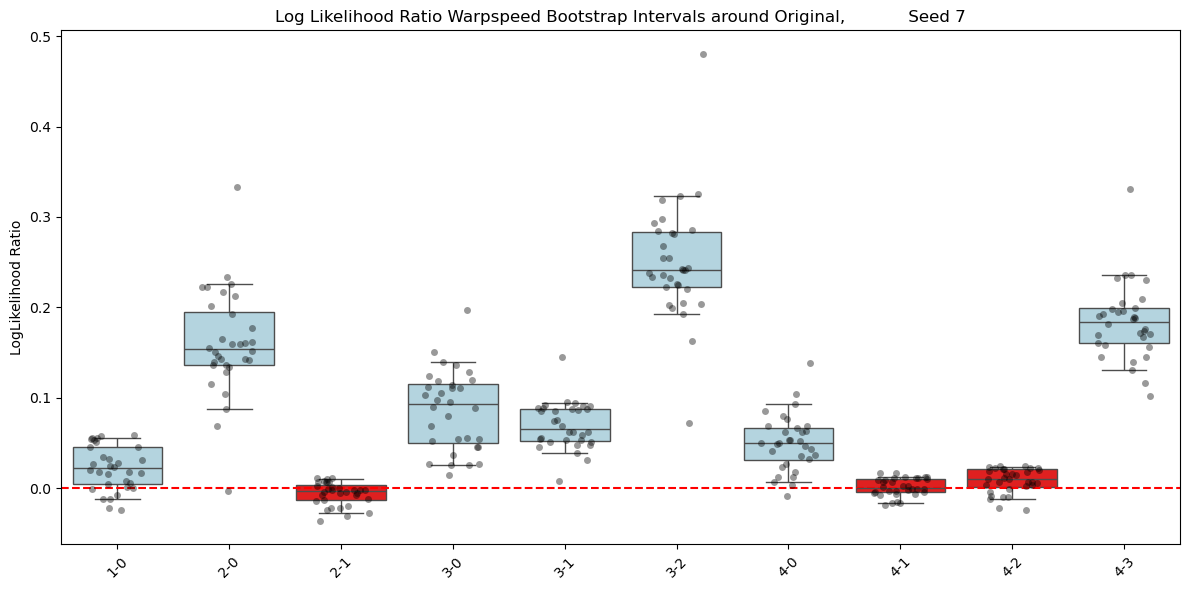

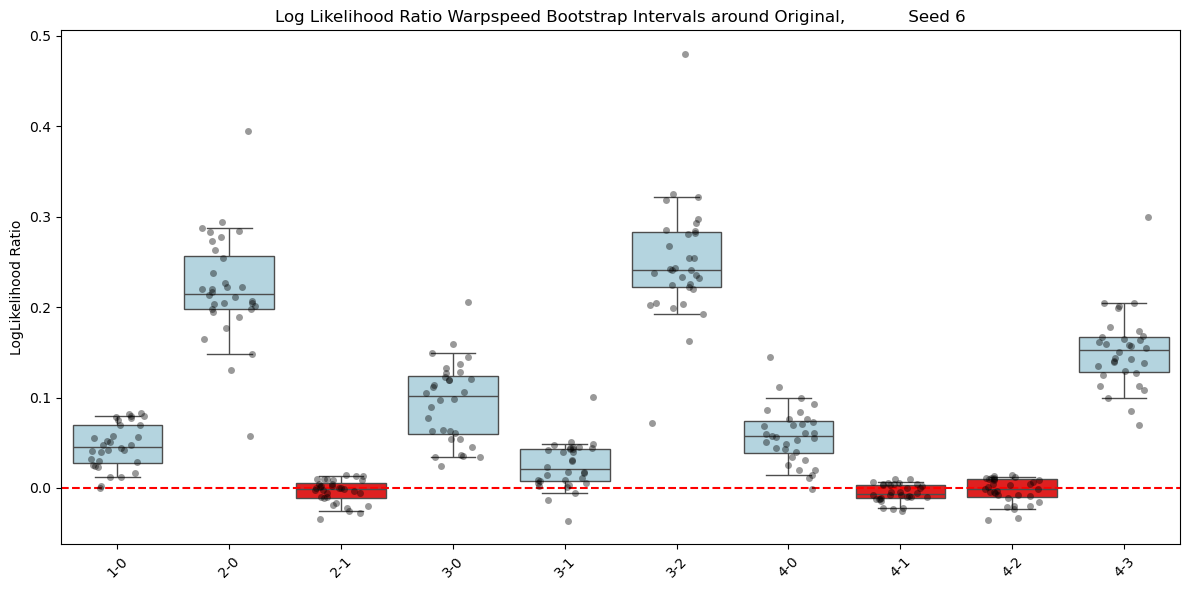

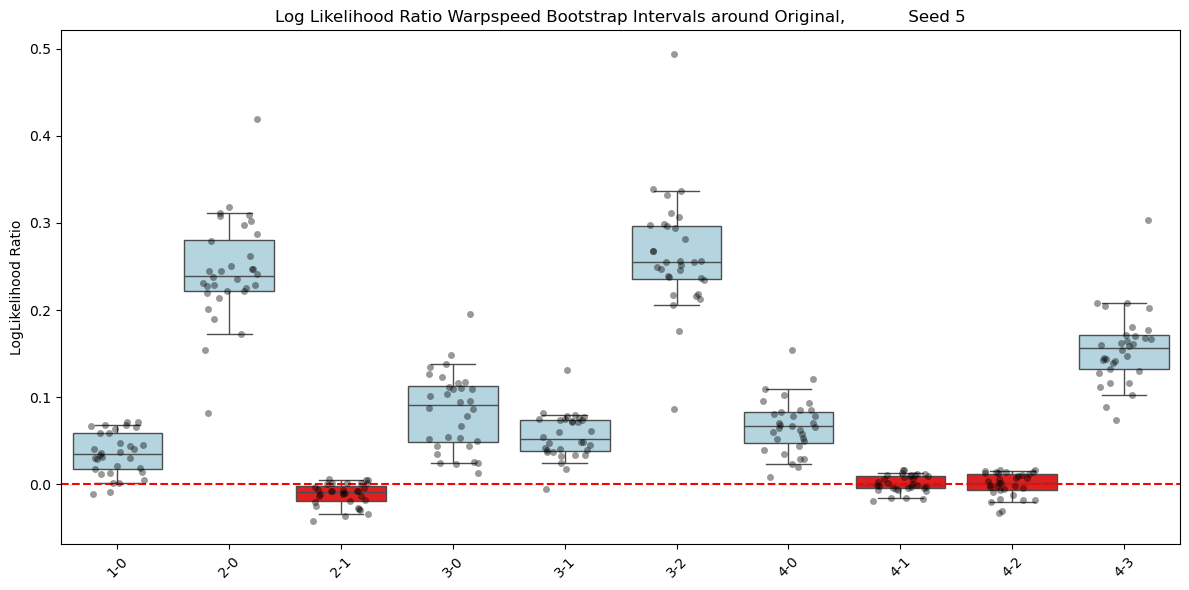

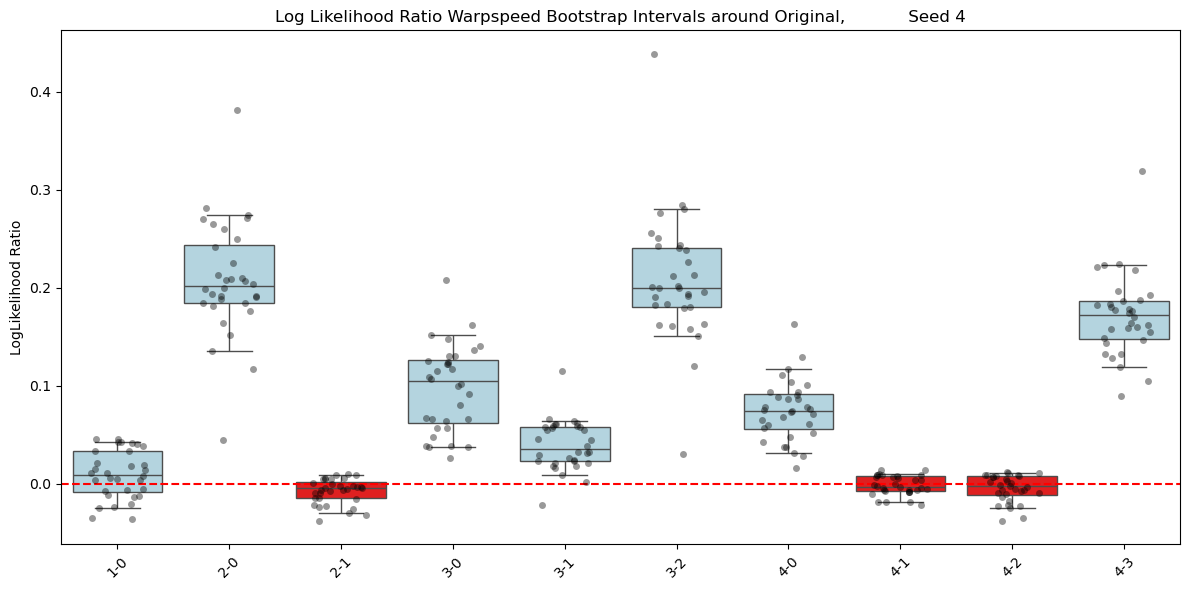

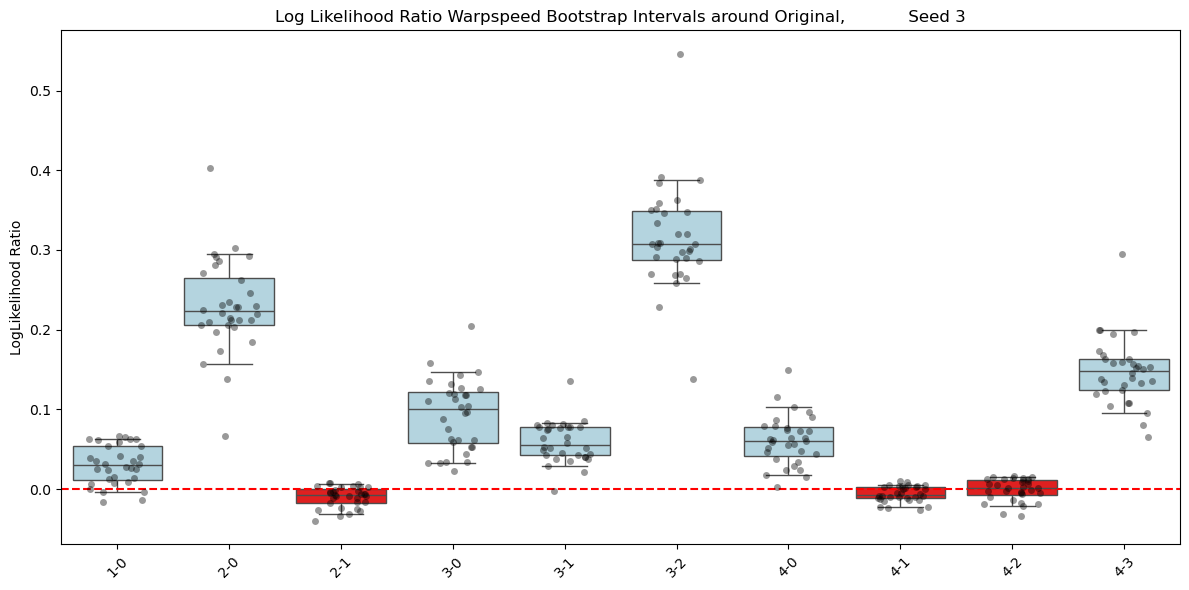

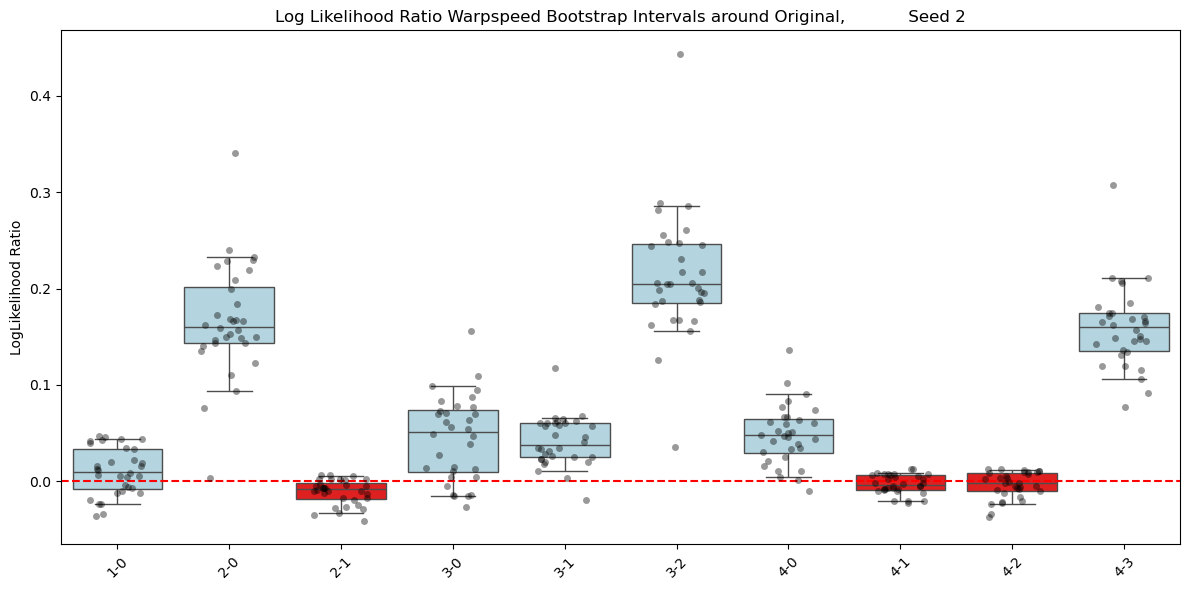

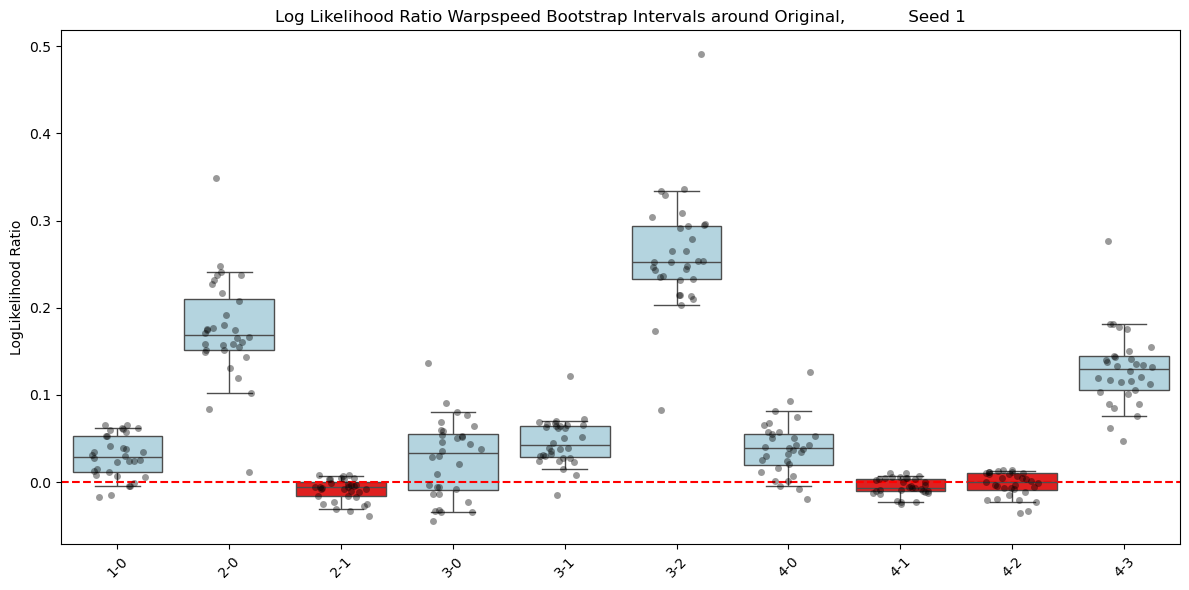

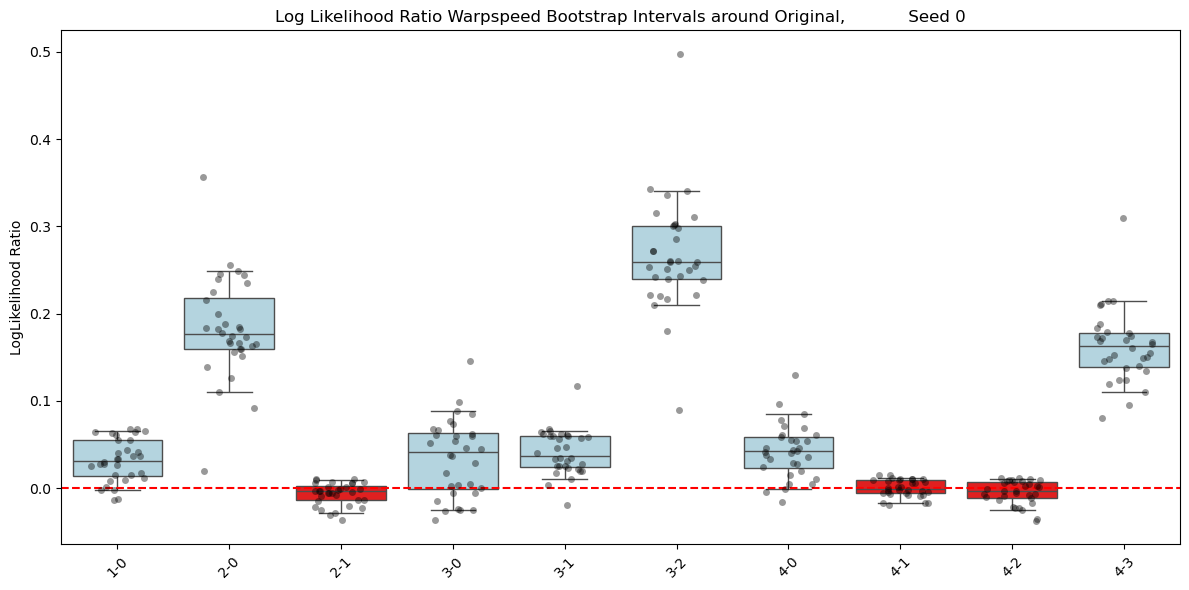

In [16]:
# for each seed plot boxplot of differences around orginal kld

for seed in df_runs['tags.seed_value'].unique():
    table_original = table_original_dict[seed]

    # add vector to the 
    centered_data = pd.DataFrame(dict_diffs) + np.array(table_original[metric])

    # check that the centering worked for all columns
    if all((pd.DataFrame(dict_diffs).iloc[:,0] + np.array(table_original[metric])[0]) == centered_data.iloc[:,0]):
        pass
    else:
        print("Centering failed.")
        
    if all((pd.DataFrame(dict_diffs).iloc[:,3] + np.array(table_original[metric])[3]) == centered_data.iloc[:,3]):
        pass
    else:
        print("Centering failed.")

    plt.figure(figsize=(12, 6))
    
    
    #sns.violinplot(data=centered_data)
    
    # --- Boxplot with 90% interval (whis=[5, 95]) ---
    sns.boxplot(data=centered_data, whis=[5, 95], showfliers=False, palette=['lightblue','lightblue','red','lightblue','lightblue',
                                                                             'lightblue','lightblue','red','red','lightblue'])
    # Colors on independence from above

    # --- Show data points overlaid (jittered) ---
    # Use stripplot for point overlay; set jitter for clarity
    sns.stripplot(data=centered_data, color='black', alpha=0.4, dodge=True, jitter=0.25)
    
    
    plt.axhline(0, color='red', linestyle='--')
    plt.ylabel("LogLikelihood Ratio")
    plt.title("Log Likelihood Ratio Warpspeed Bootstrap Intervals around Original,            Seed " + str(seed))
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

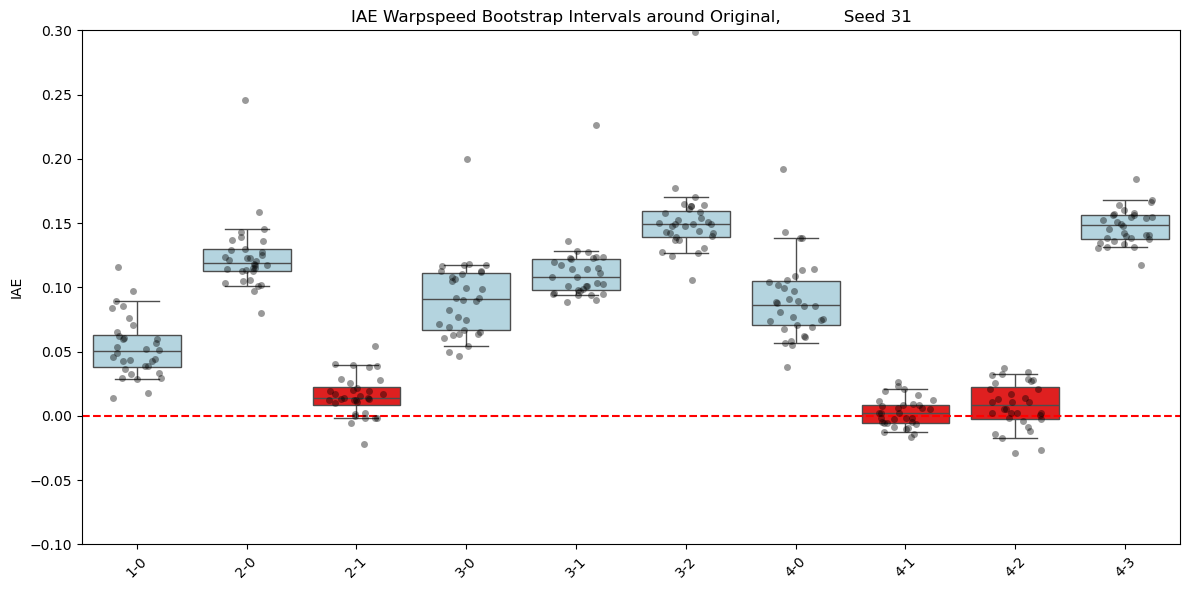

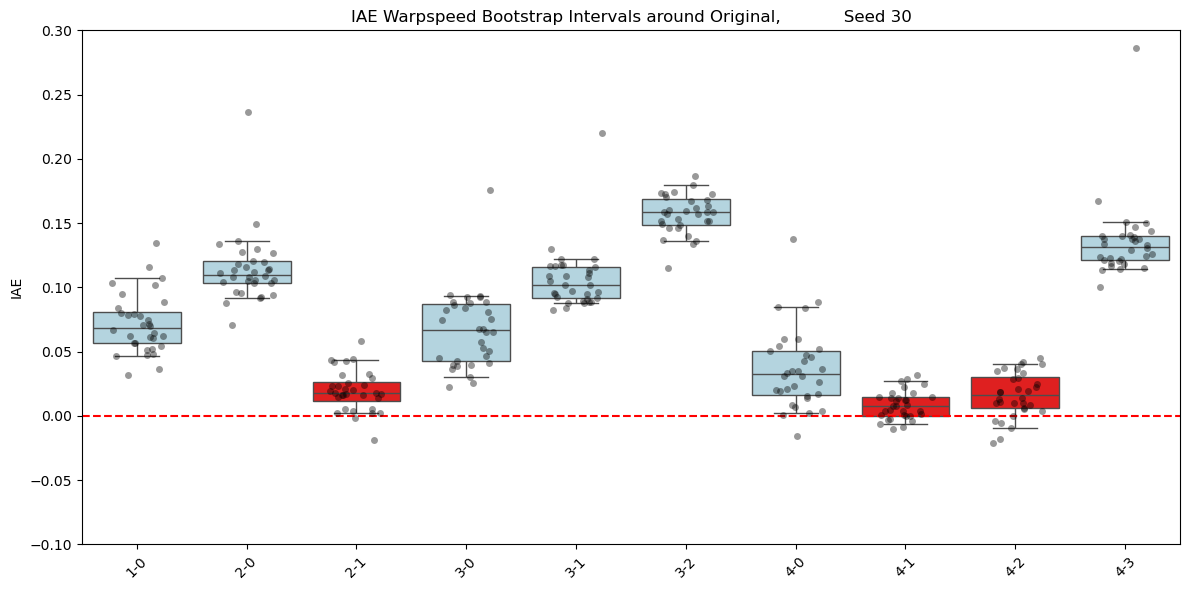

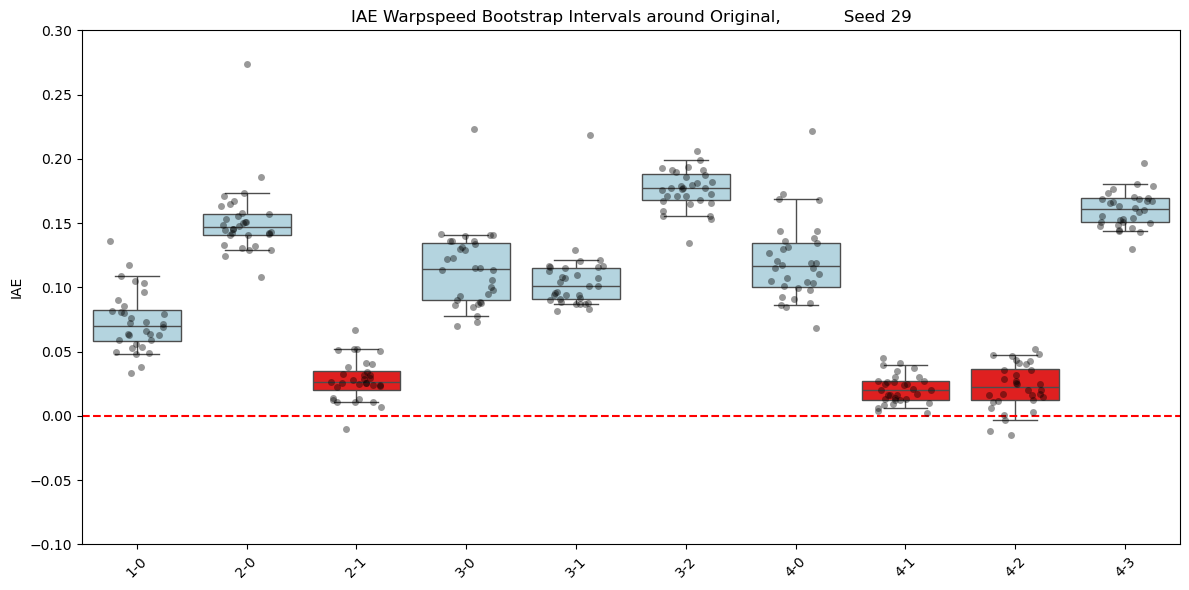

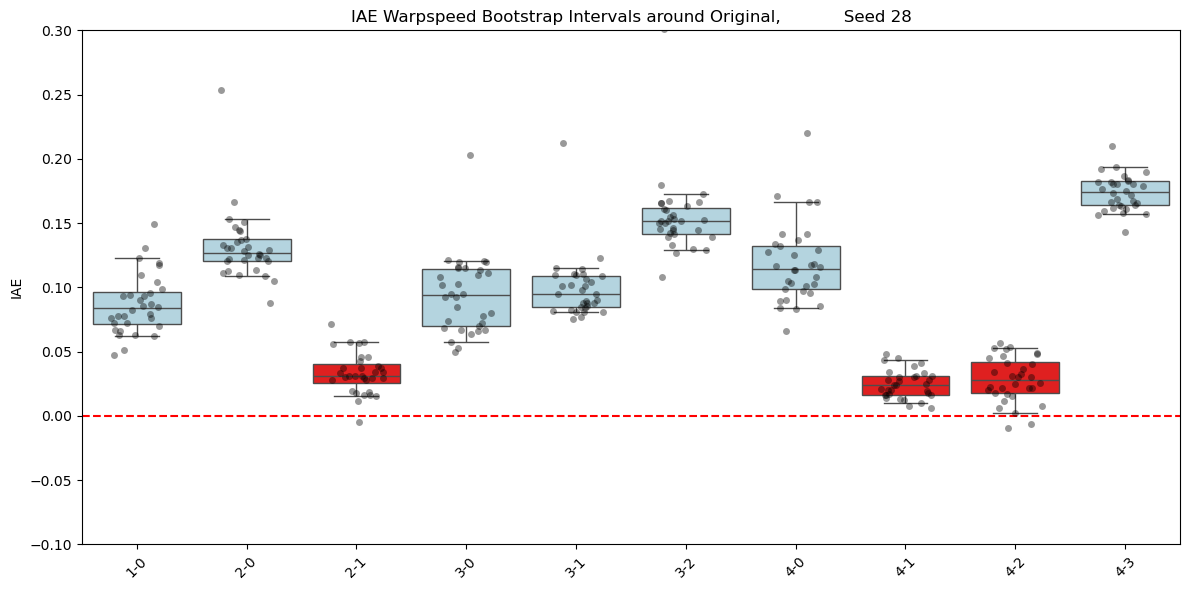

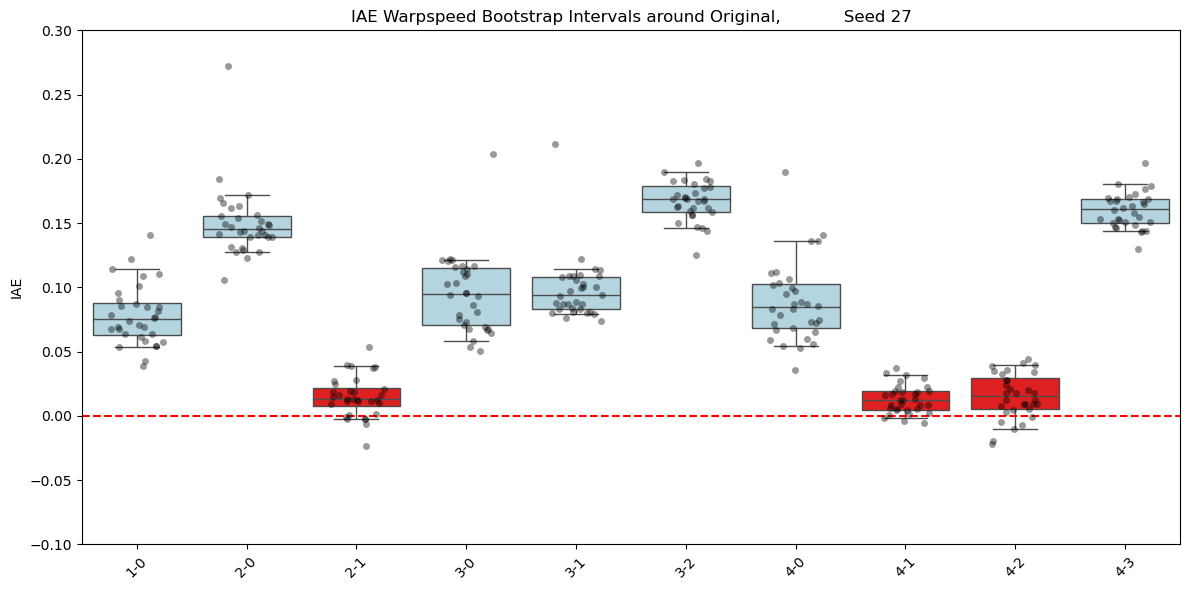

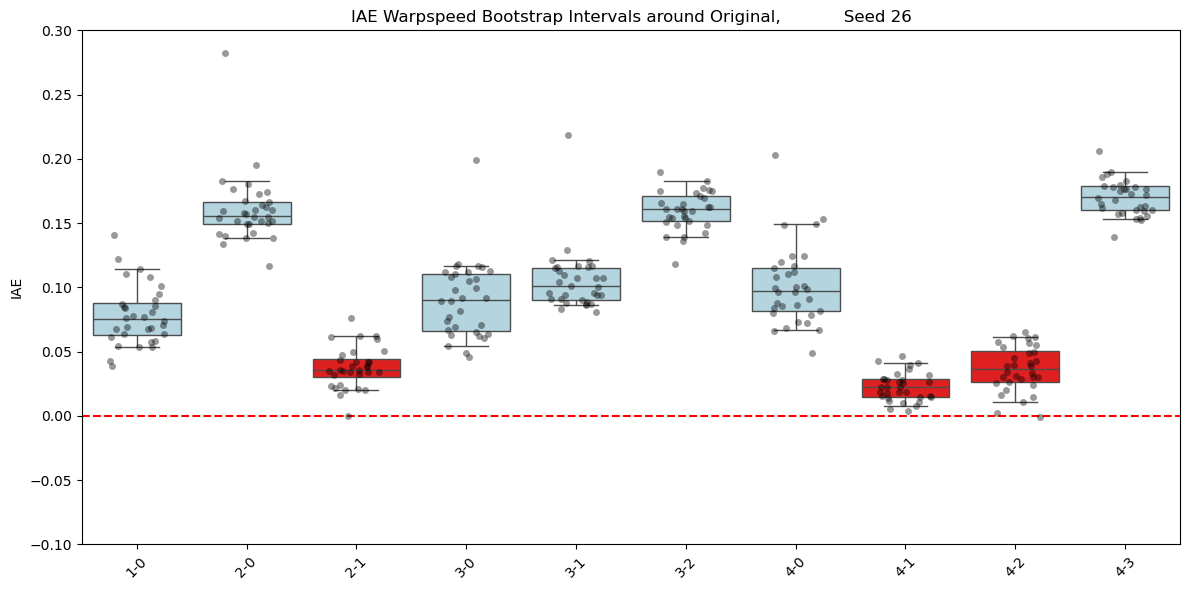

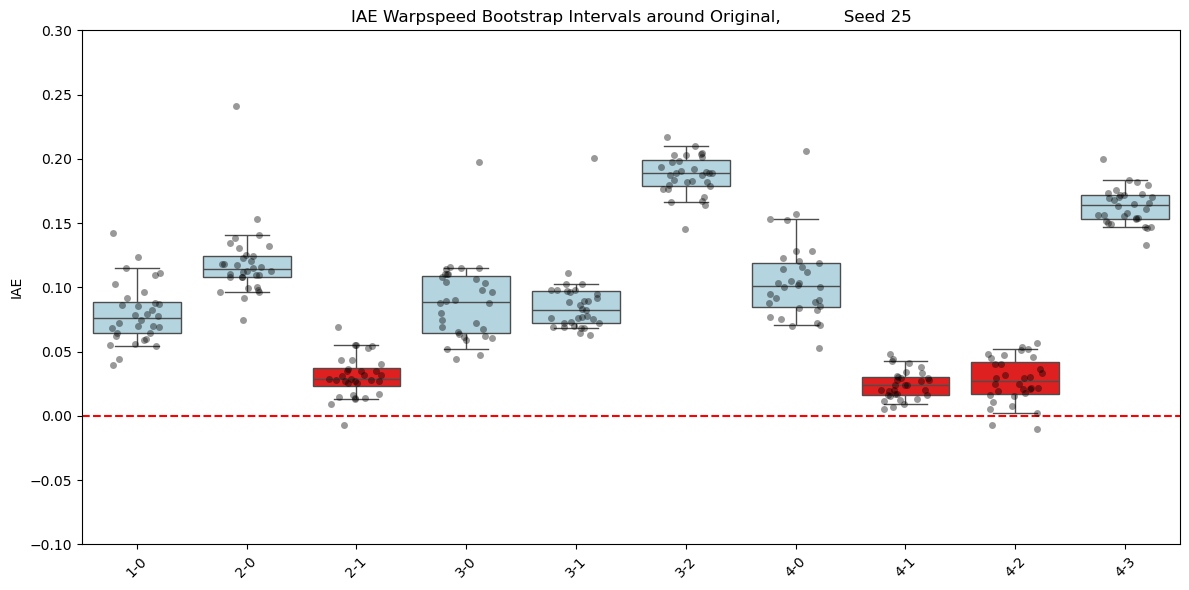

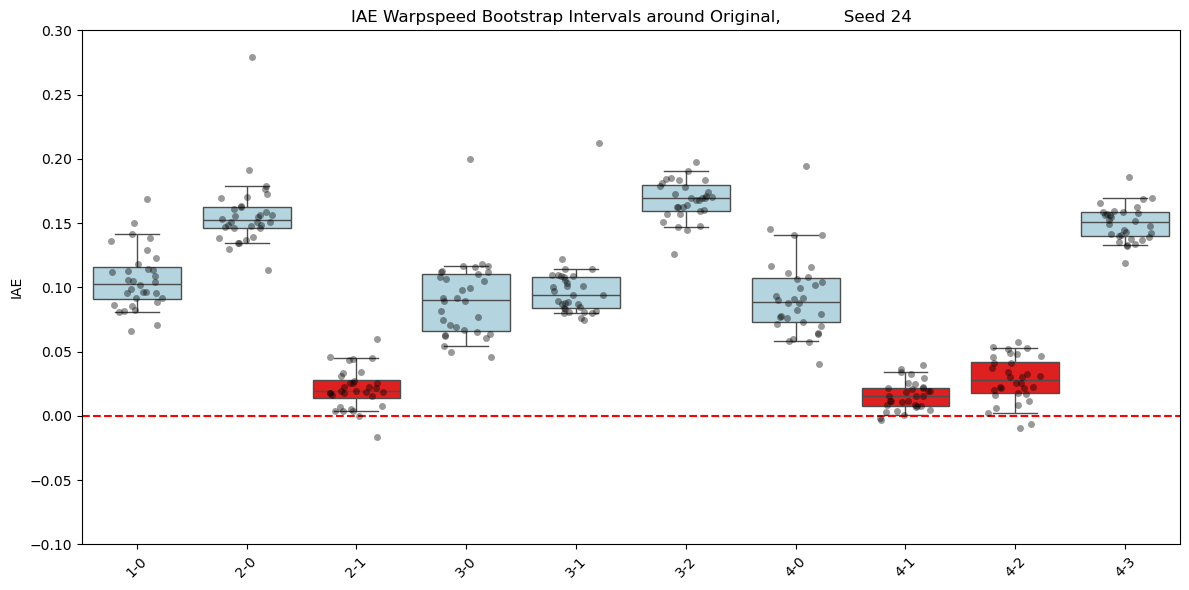

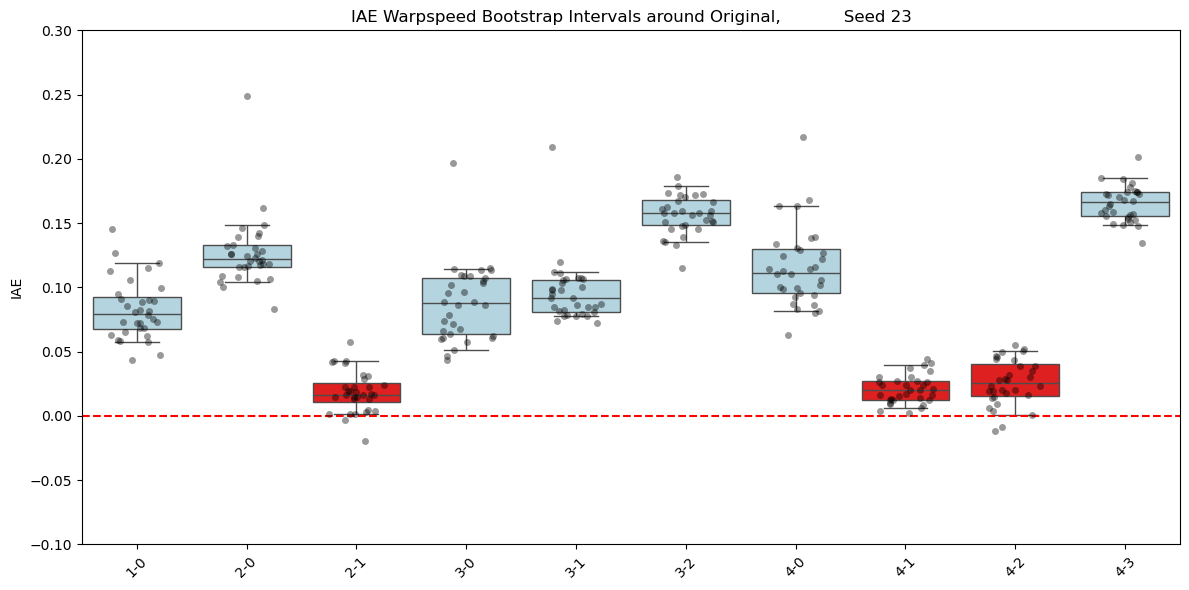

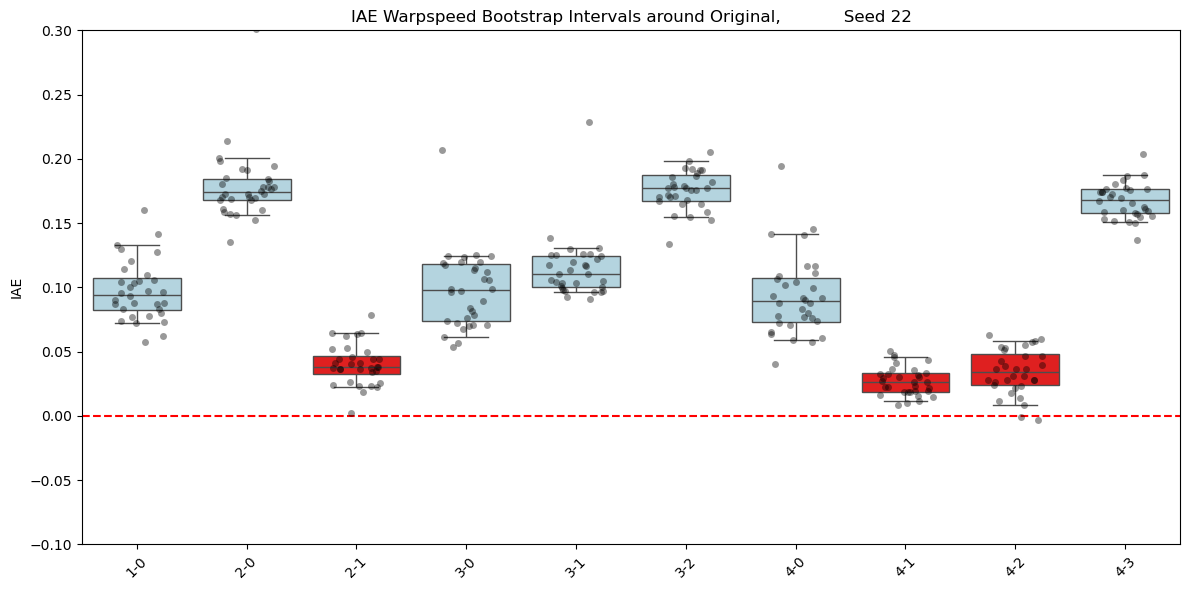

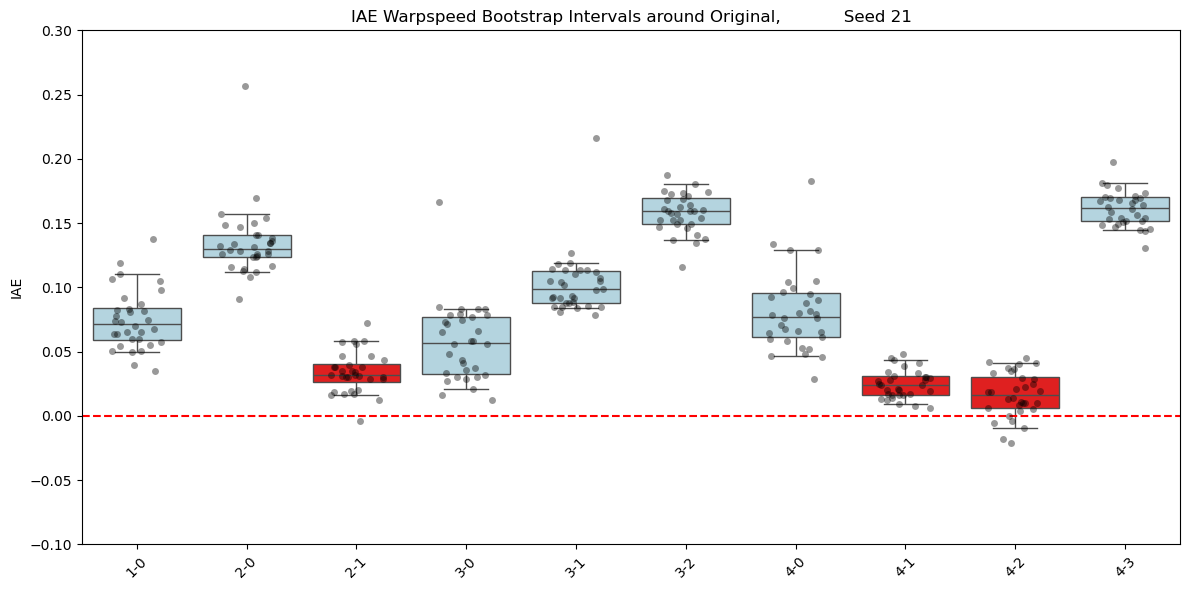

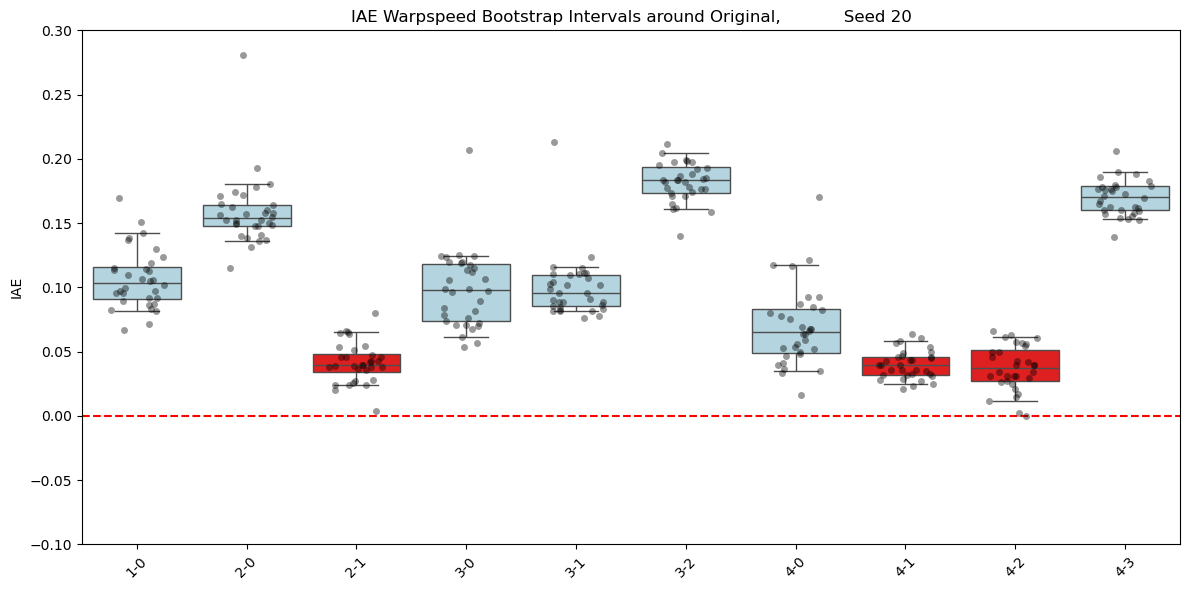

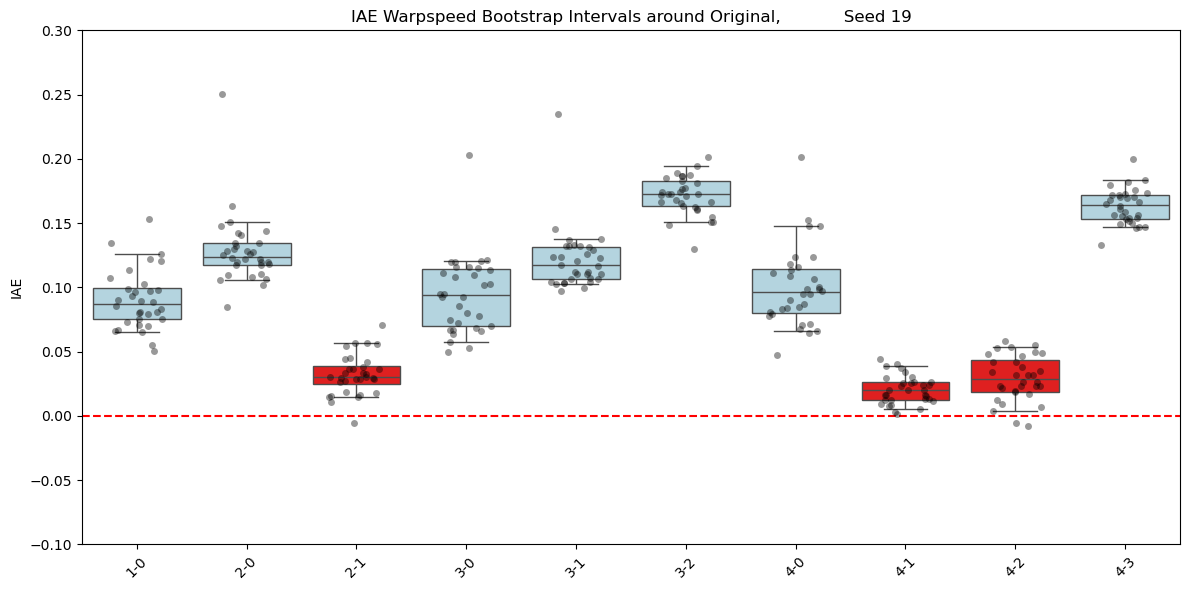

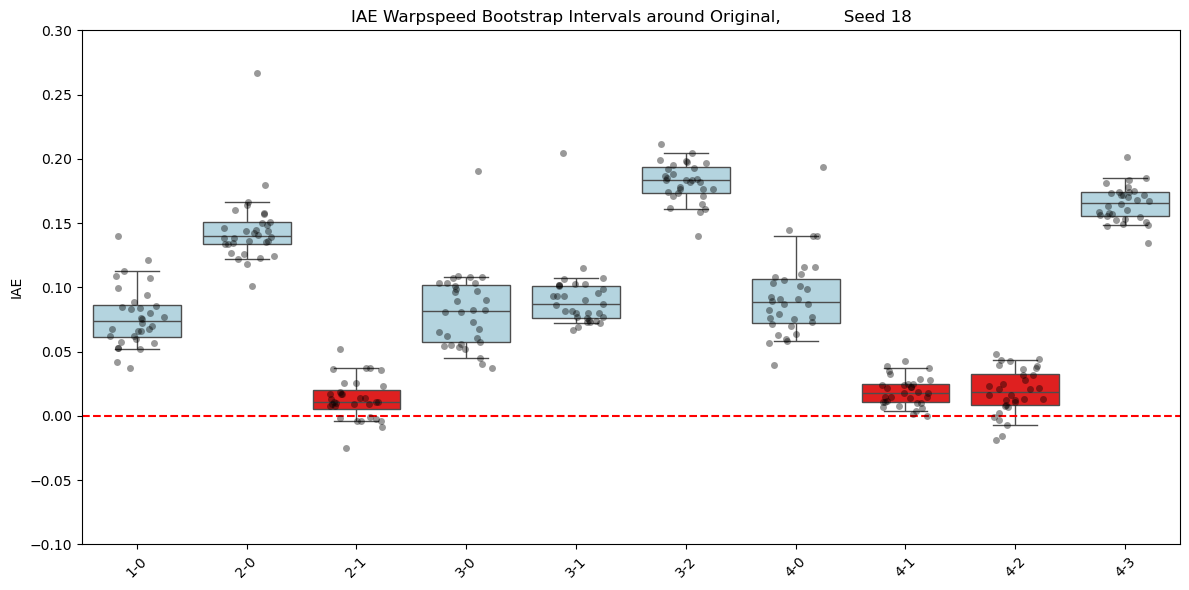

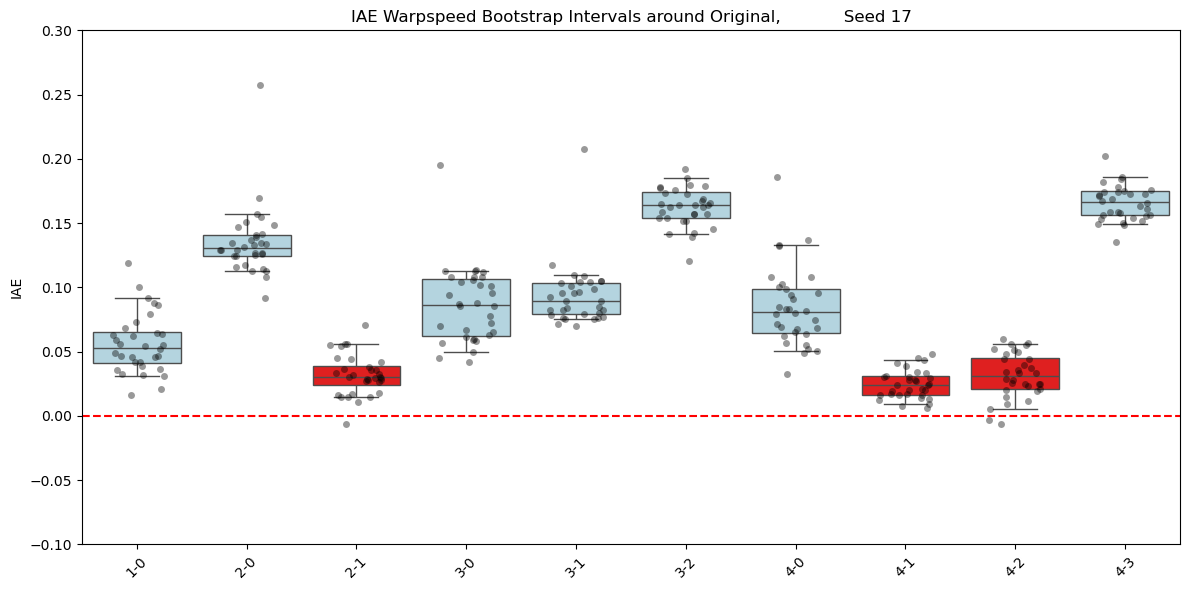

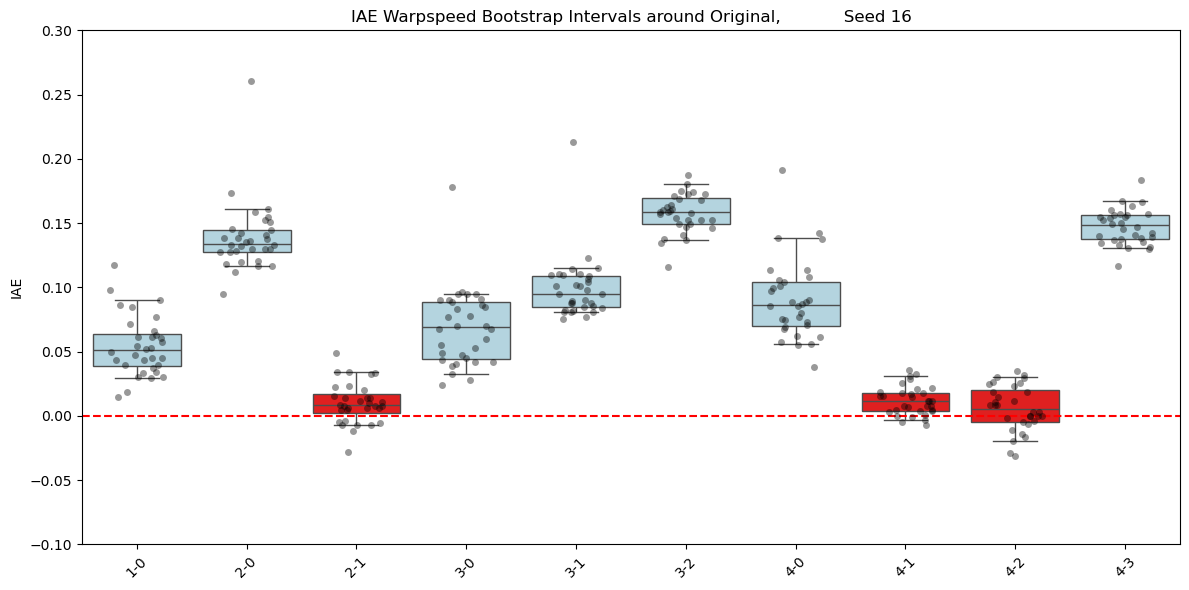

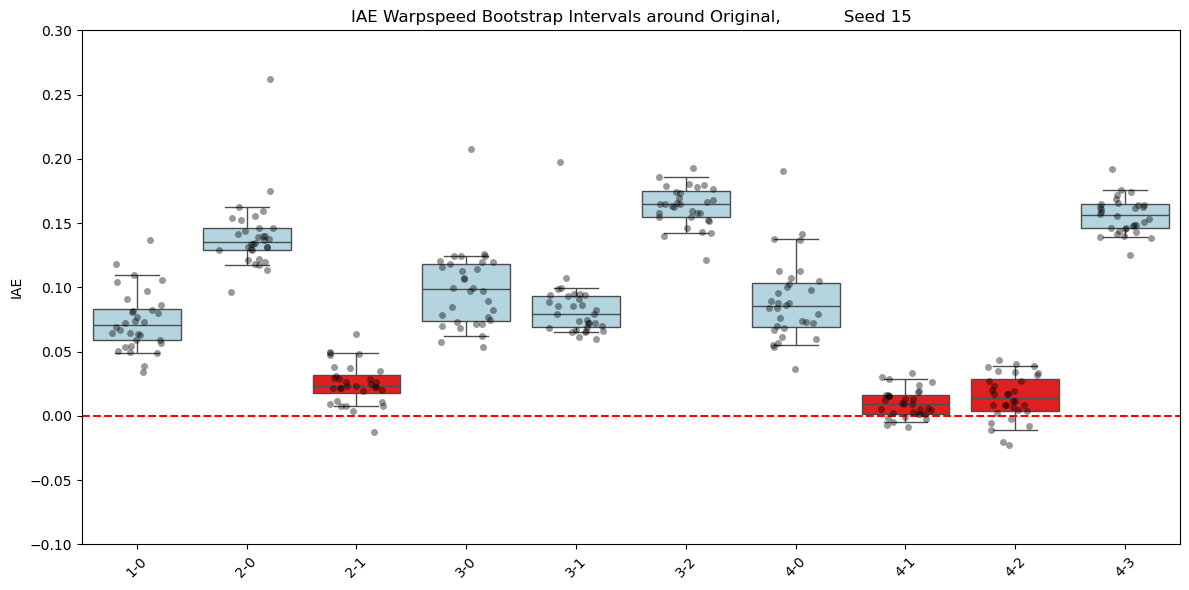

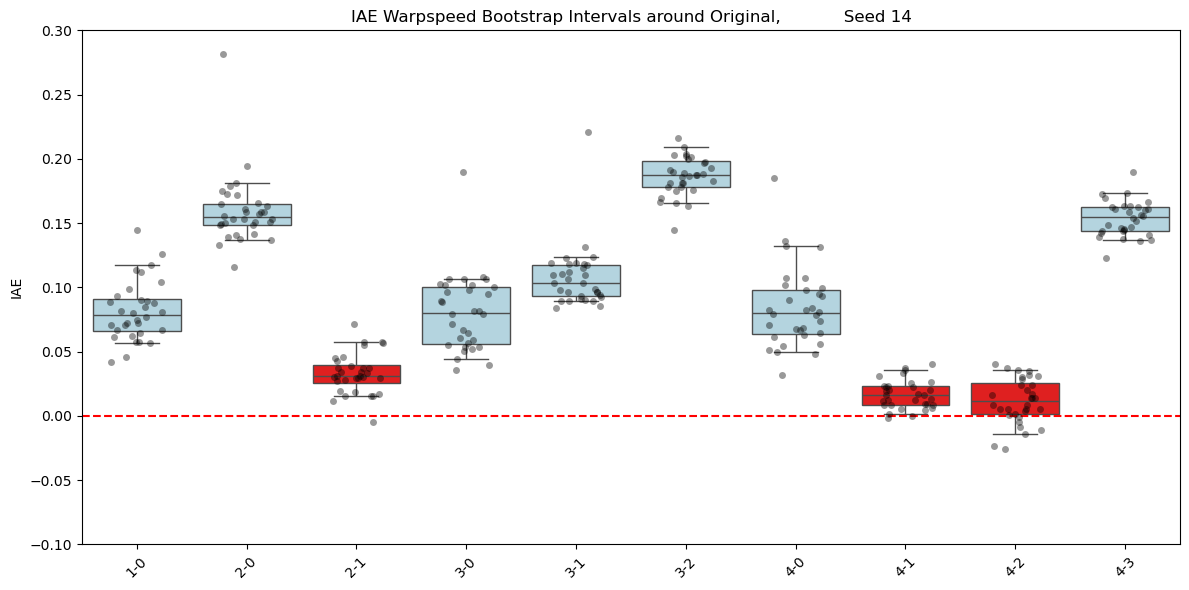

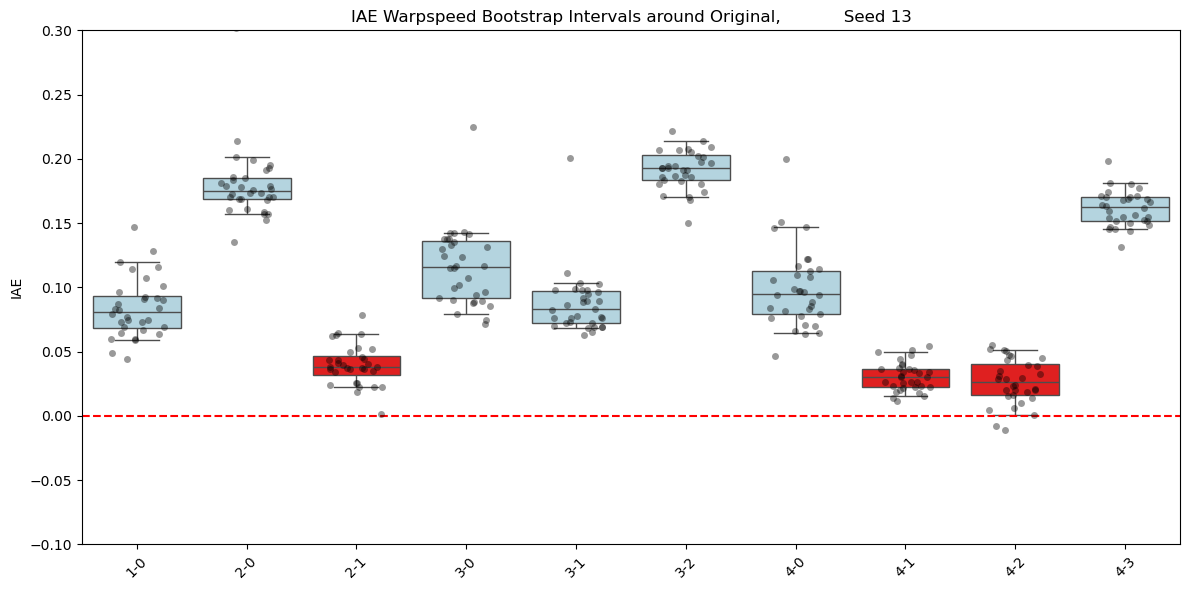

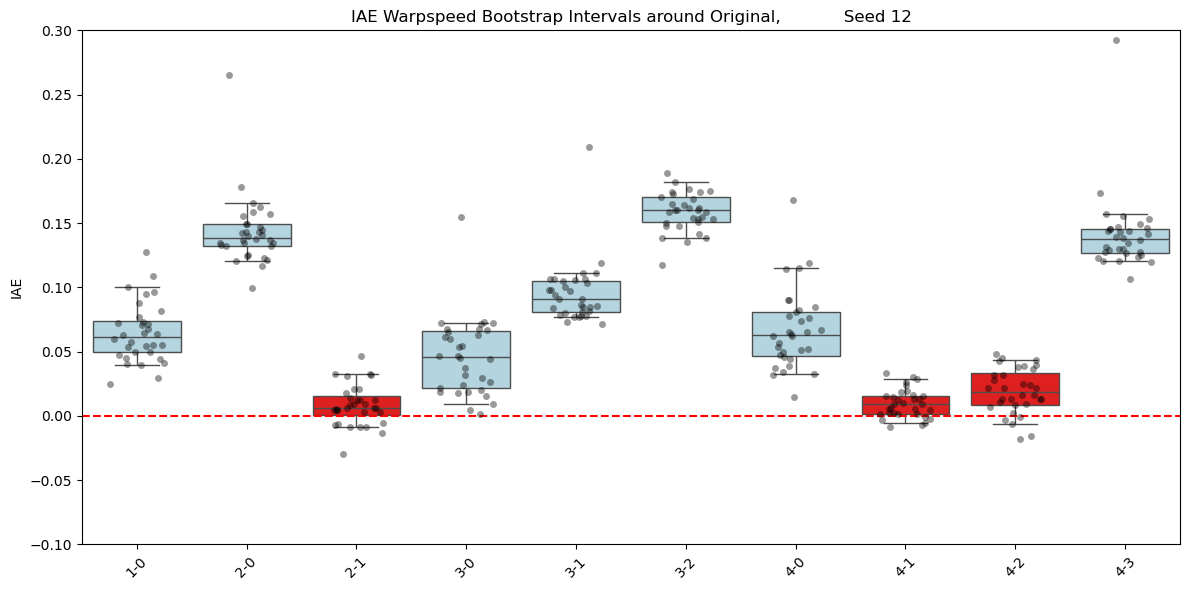

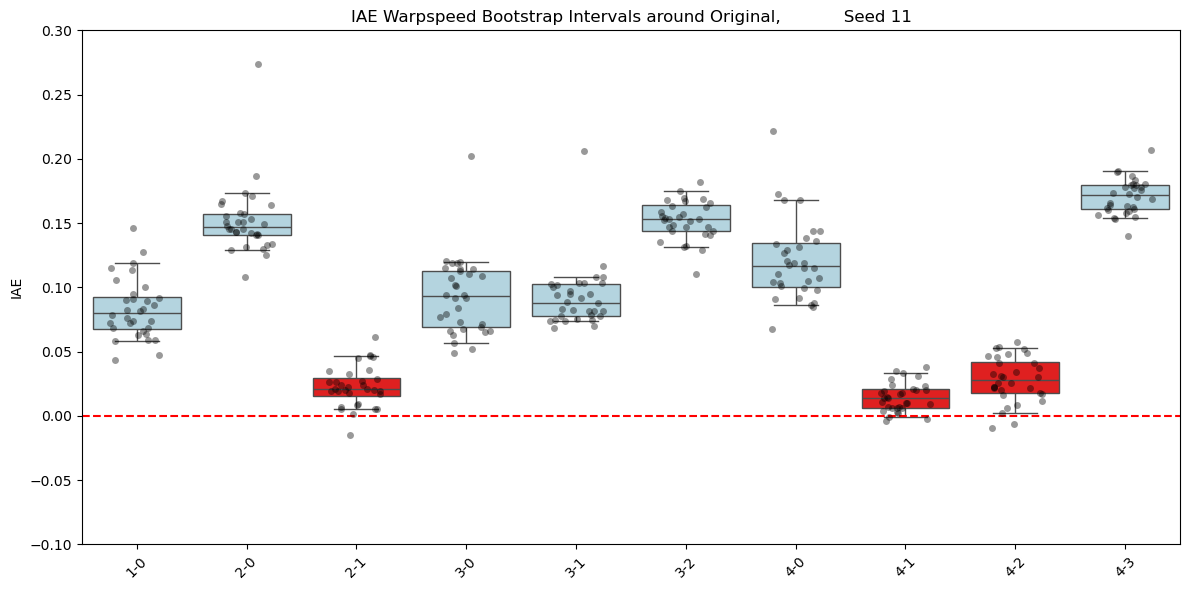

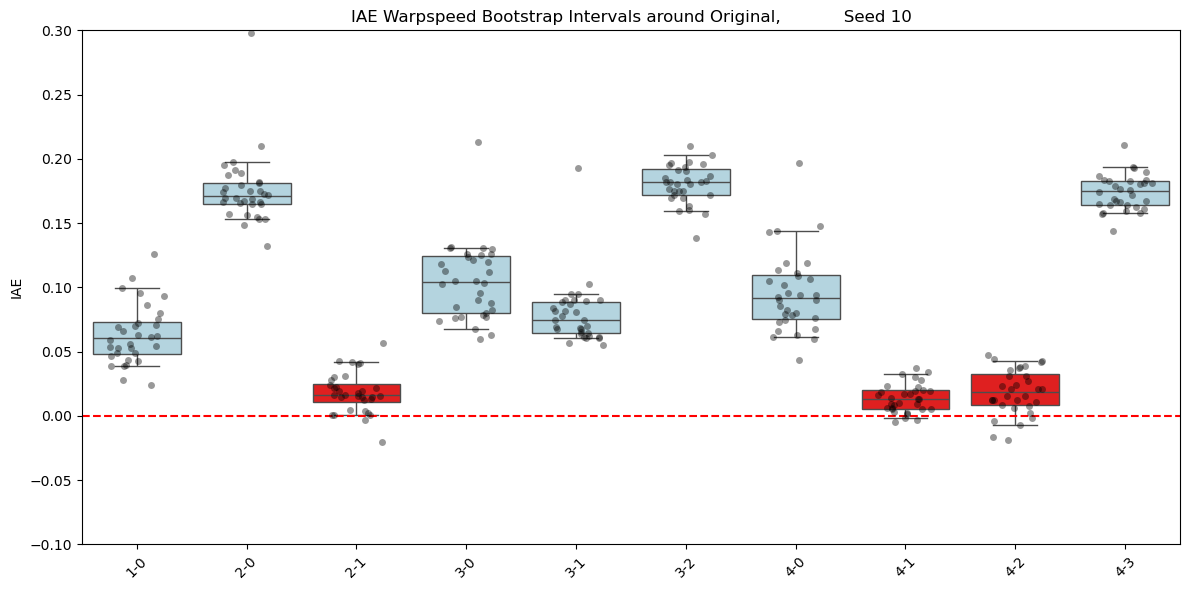

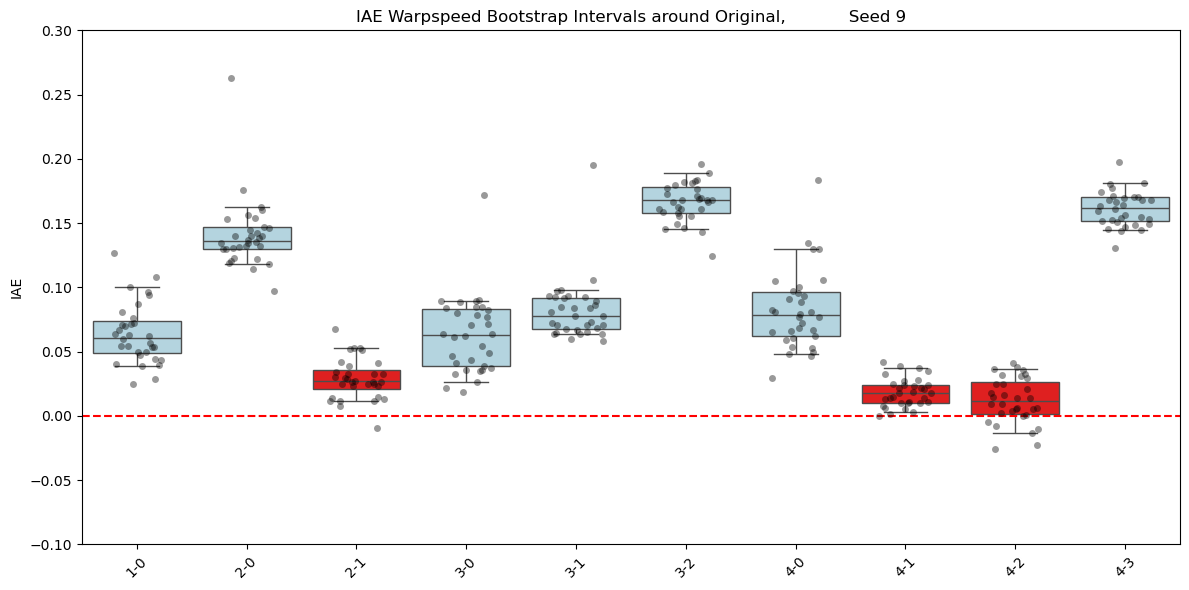

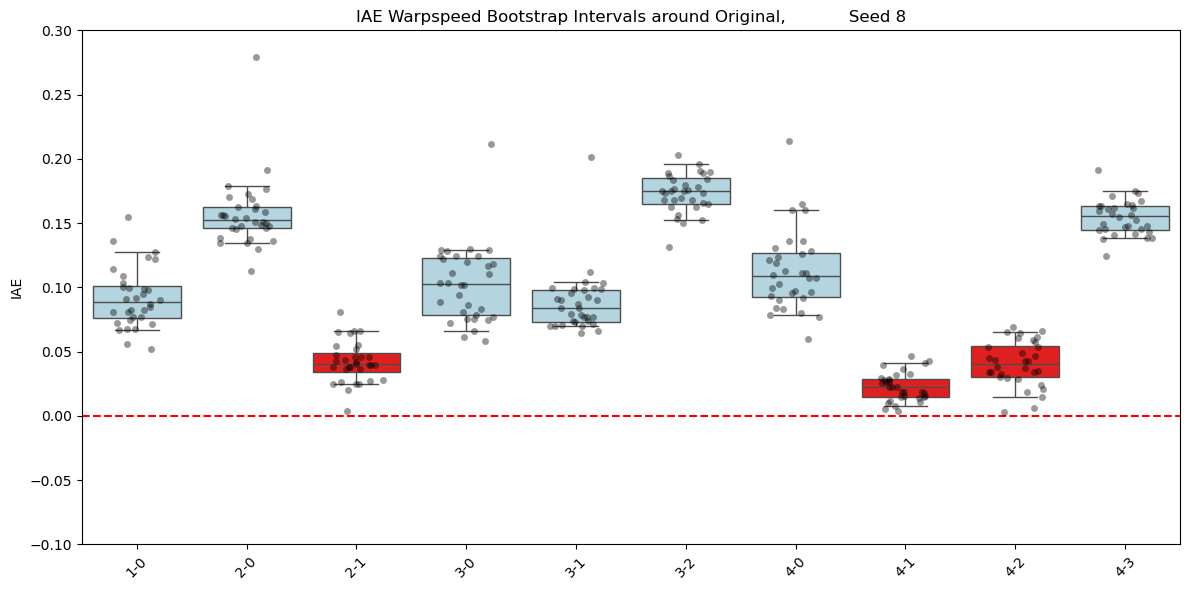

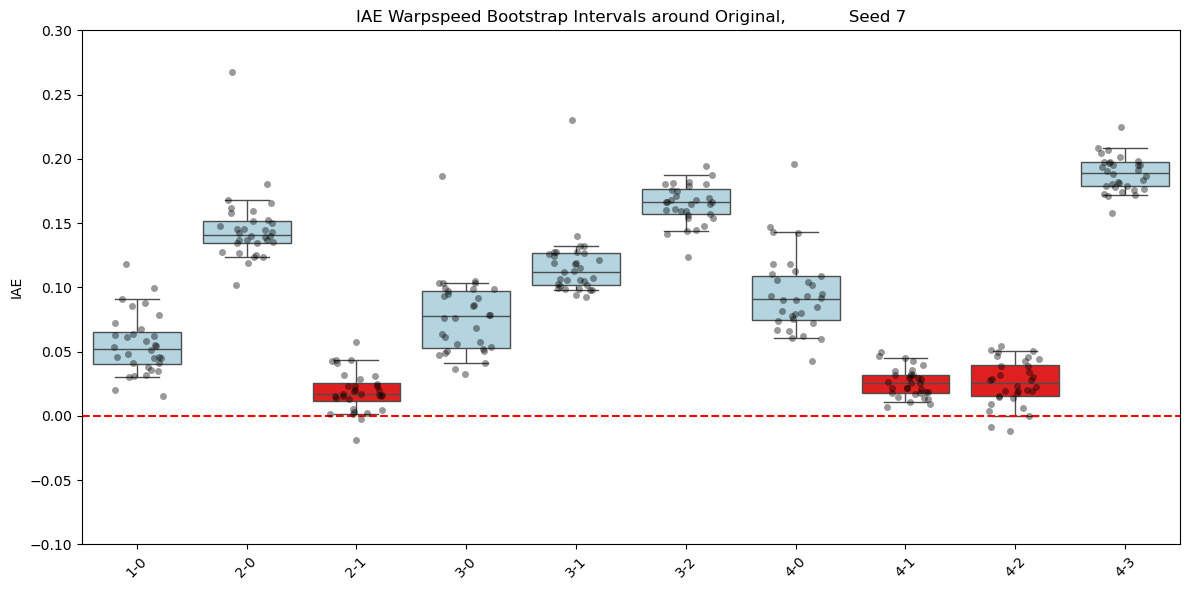

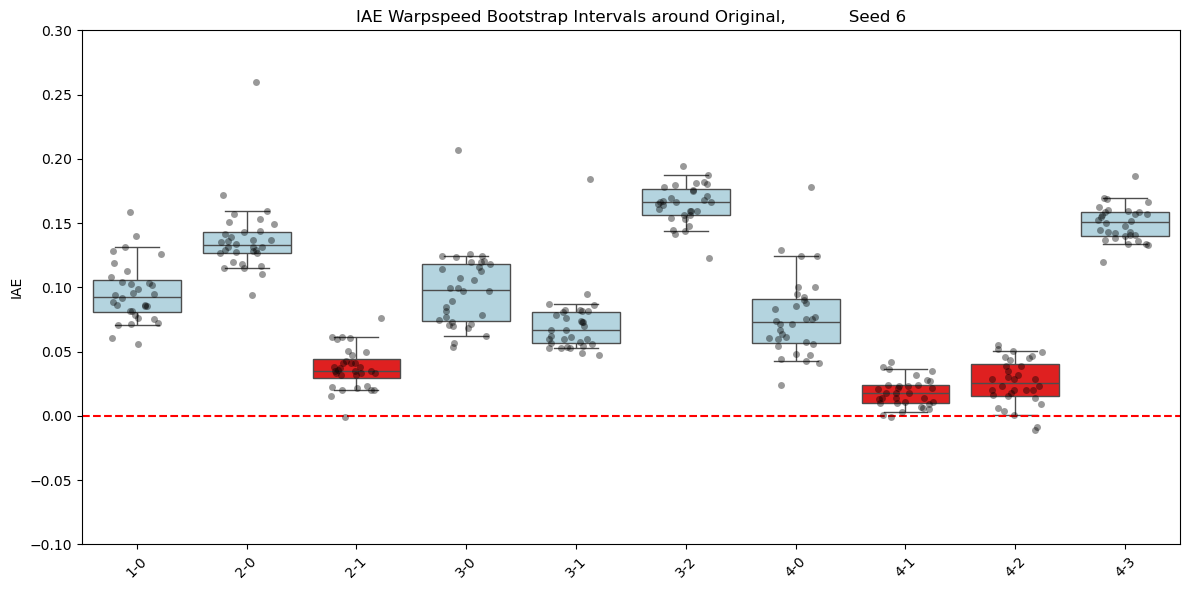

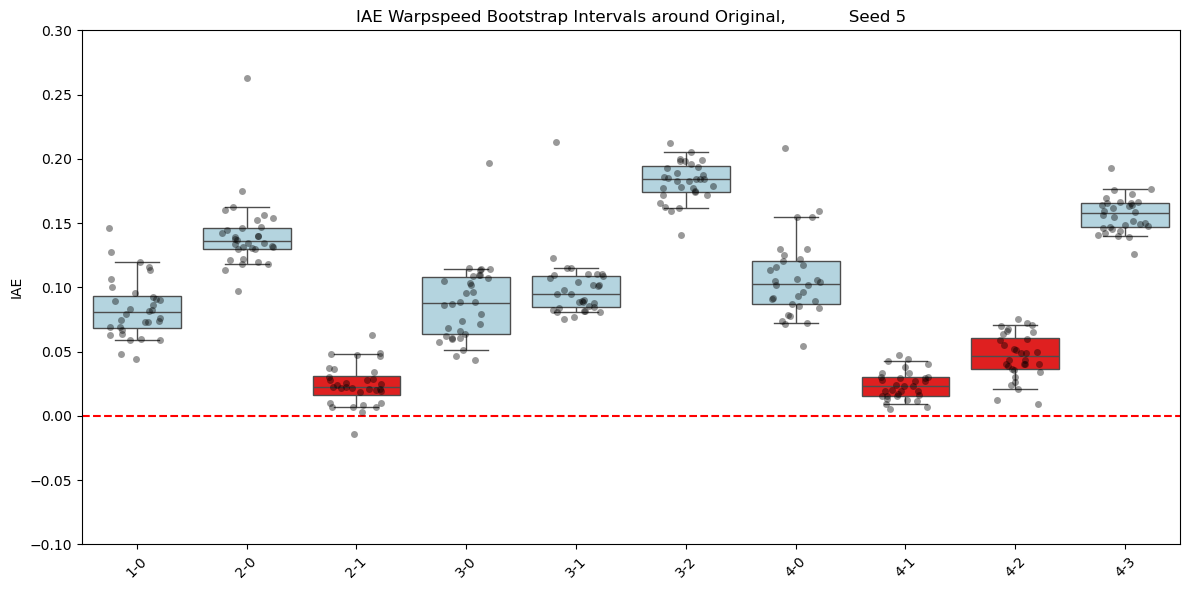

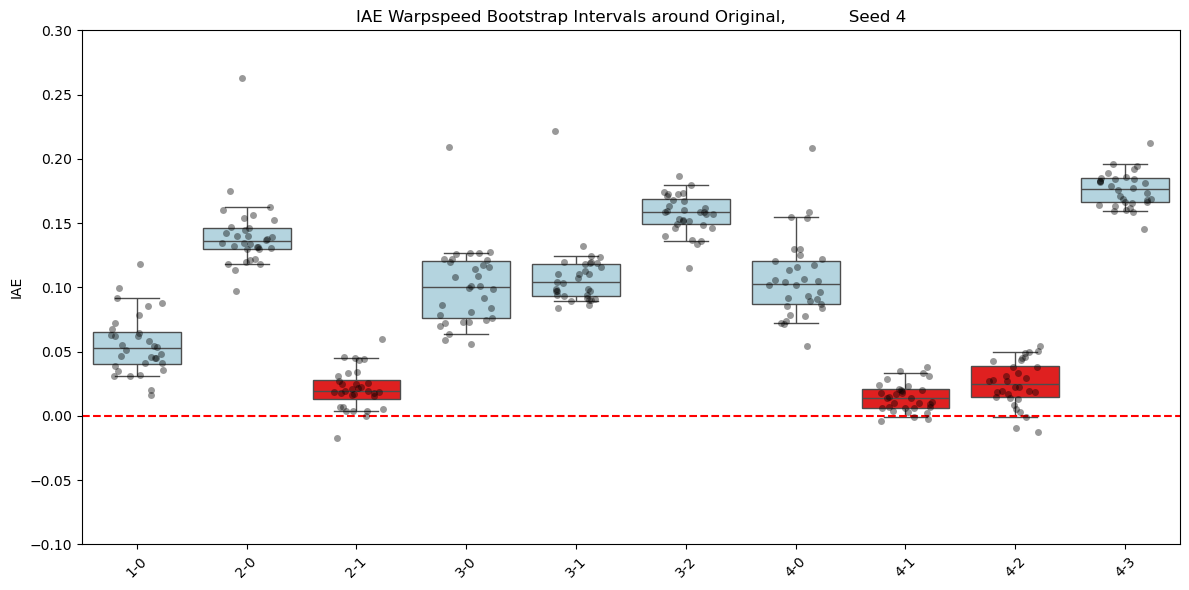

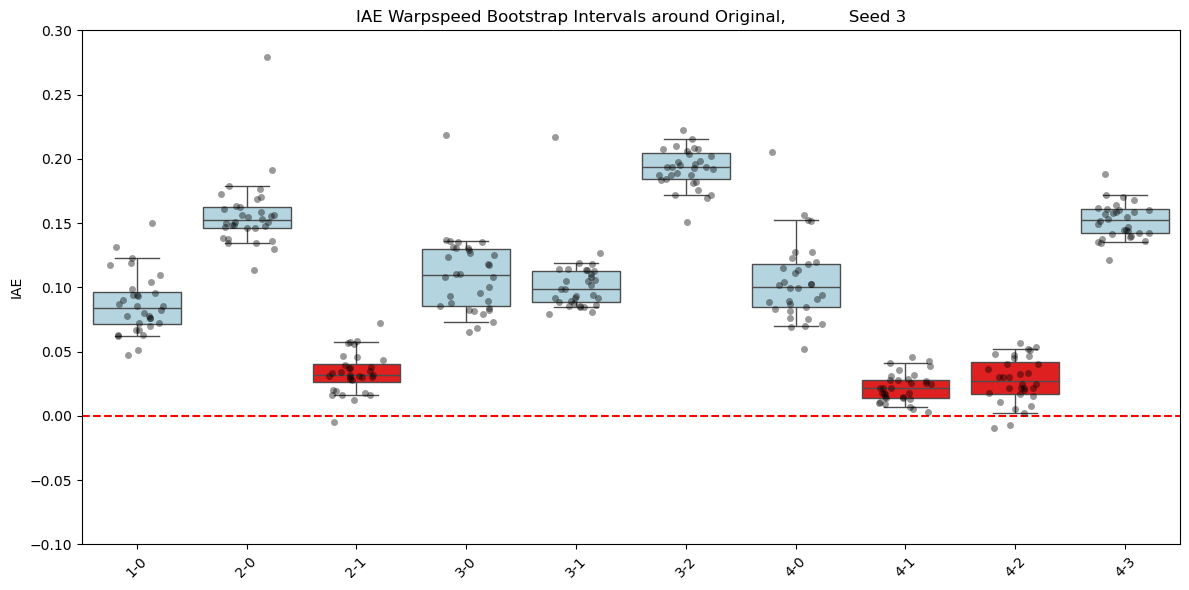

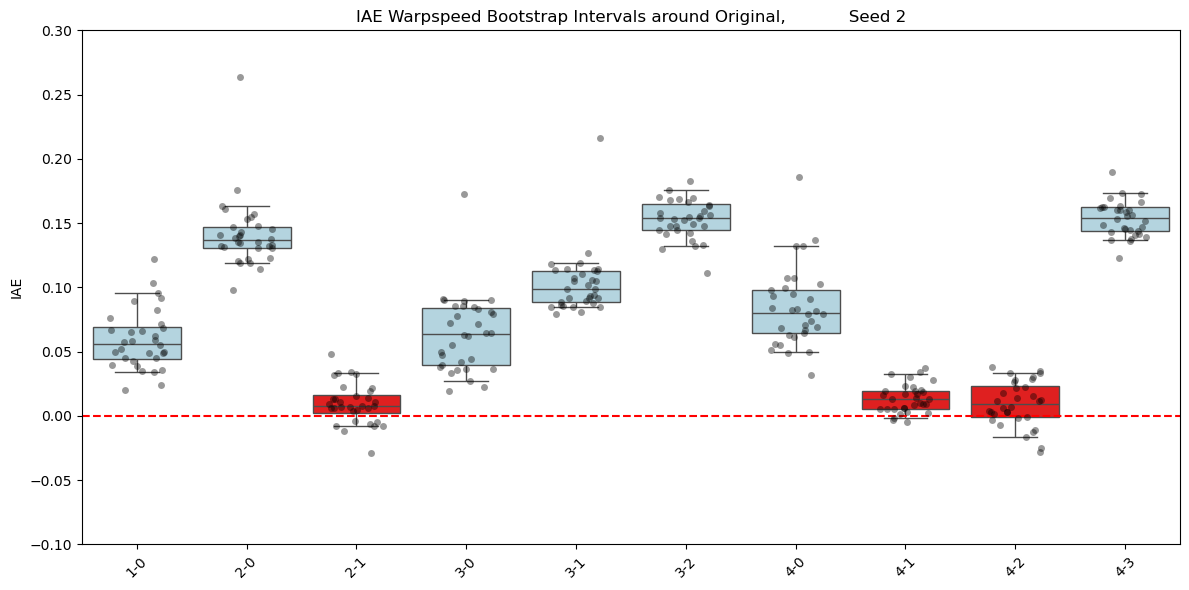

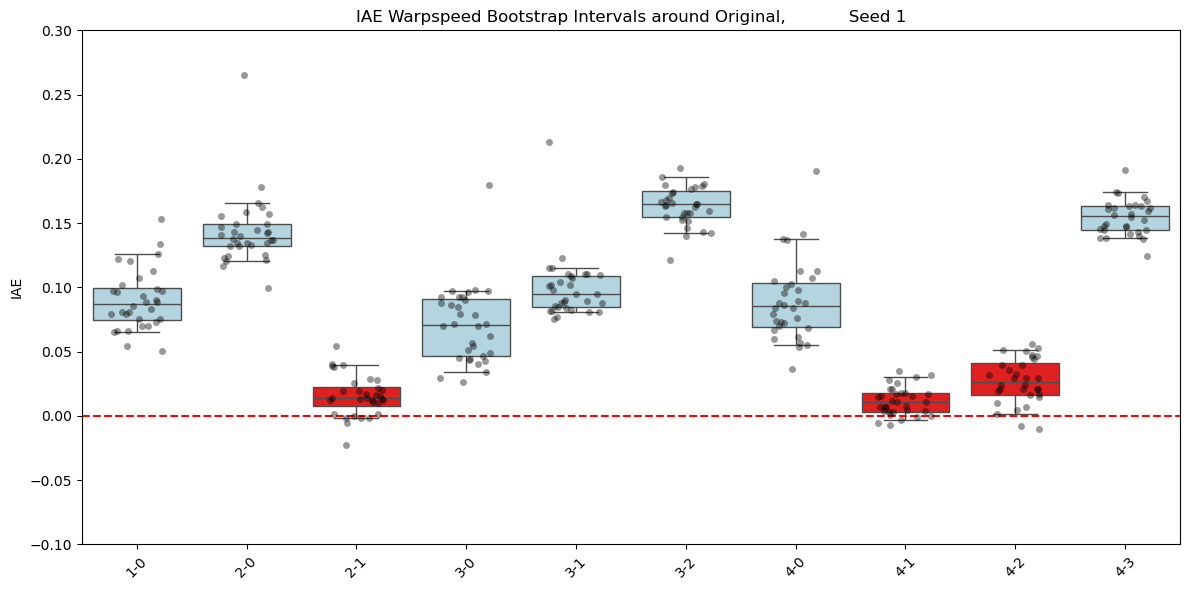

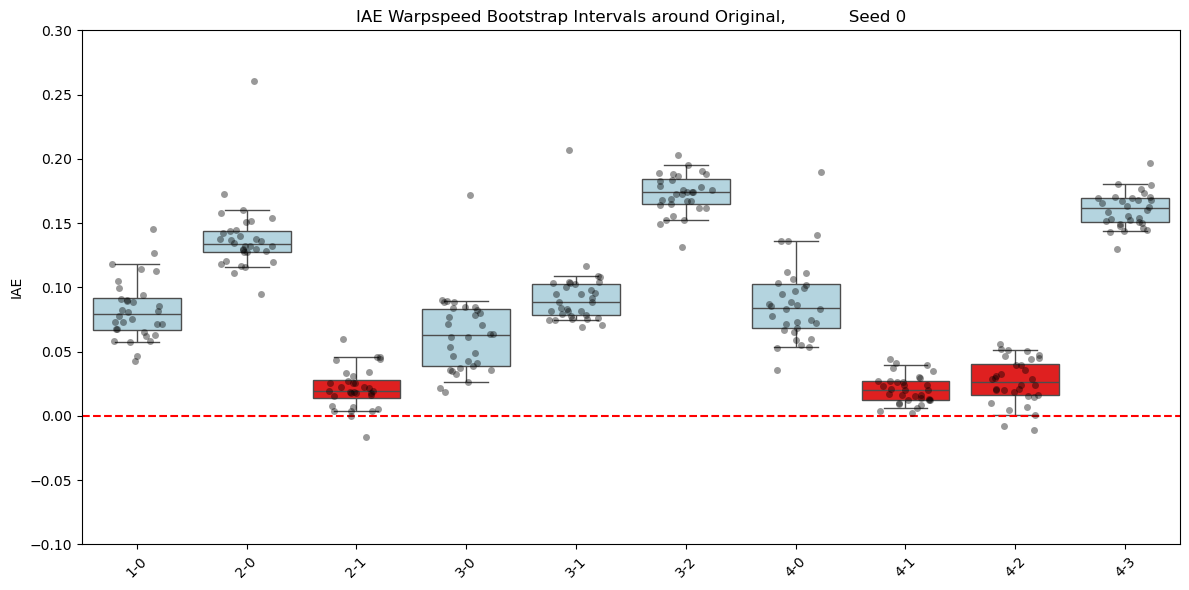

In [17]:
metric = "iae"

# load aritfact conditional_independence_table_data_validate.csv
#artifact_path = "conditional_independence_table_model_samples.csv"

# TEMPORARY: all seeds except 83 ad 48 as incomplete
#df_runs = df_runs[df_runs['tags.seed_value'] != str(83)]
#df_runs = df_runs[df_runs['tags.seed_value'] != str(48)]

N_train = df_runs['tags.N_train'].astype(int).iloc[0].item()
N_validate = df_runs['tags.N_validate'].astype(int).iloc[0].item()
N_train_proportion = N_train / (N_train + N_validate)
N_validate_proportion = N_validate / (N_train + N_validate)

table_diffs_list = []
table_original_dict = {}
for seed in df_runs['tags.seed_value'].unique():

    df_of_seed = df_runs[df_runs['tags.seed_value']==str(seed)]
    
    # TEMPORARY: for future bootstrap_warpspeed is a tag for now out of name
    bootstrap_bool = df_of_seed["tags.mlflow.runName"].str.contains("bootstrap")
    df_run_bootstrap = df_of_seed[bootstrap_bool]
    df_run_original = df_of_seed[~bootstrap_bool]

    # for train data and validate data
    artifact_path = "conditional_independence_table_model_samples.csv" 
    table_bootstrap = pd.read_csv(mlflow.artifacts.download_artifacts(run_id=df_run_bootstrap['run_id'].item(), artifact_path=artifact_path))
    table_original = pd.read_csv(mlflow.artifacts.download_artifacts(run_id=df_run_original['run_id'].item(), artifact_path=artifact_path))
     
    # check same ordering of var_row and var_col
    table_original.sort_values(by=['var_row', 'var_col'], inplace=True)
    table_bootstrap.sort_values(by=['var_row', 'var_col'], inplace=True)

    # check columns same:
    if table_original["var_col"].equals(table_bootstrap["var_col"]) and table_original["var_row"].equals(table_bootstrap["var_row"]):
        pass
    else:
        raise ValueError("var_row and var_col do not match between original and bootstrap tables")
    
    # compute difference in tables for all except first 3 columns and last 3, laster are infors of dependence, tau of copula and copula
    table_diff = table_original.copy()
    table_diff.iloc[:, 3:9] = table_original.iloc[:, 3:9] - table_bootstrap.iloc[:, 3:9] 
    
    # across all seeds store the differences table in a joint array
    table_diffs_list.append(table_diff)
    table_original_dict[seed] = table_original

    
dict_diffs = {}
for pair in zip(table_original['var_row'], table_original['var_col']):
    varrow = pair[0]
    varcol = pair[1]
    diffs_to_plot = []
    for table_diffs in table_diffs_list:
        diffs_value = table_diffs[(table_diffs['var_col'] == varcol) & (table_diffs['var_row'] == varrow)][metric].values[0]
        diffs_to_plot.append(diffs_value)
        
    dict_diffs[f"{int(varrow)}-{int(varcol)}"] = diffs_to_plot
    

for seed in df_runs['tags.seed_value'].unique():
    table_original = table_original_dict[seed]

    # add vector to the 
    centered_data = pd.DataFrame(dict_diffs) + np.array(table_original[metric])

    # check that the centering worked for all columns
    if all((pd.DataFrame(dict_diffs).iloc[:,0] + np.array(table_original[metric])[0]) == centered_data.iloc[:,0]):
        pass
    else:
        print("Centering failed.")
        
    if all((pd.DataFrame(dict_diffs).iloc[:,3] + np.array(table_original[metric])[3]) == centered_data.iloc[:,3]):
        pass
    else:
        print("Centering failed.")

    plt.figure(figsize=(12, 6))
    
    
    #sns.violinplot(data=centered_data)
    
    # --- Boxplot with 90% interval (whis=[5, 95]) ---
    sns.boxplot(data=centered_data, whis=[5, 95], showfliers=False, palette=['lightblue','lightblue','red','lightblue','lightblue',
                                                                             'lightblue','lightblue','red','red','lightblue'])
    # Colors on independence from above

    # --- Show data points overlaid (jittered) ---
    # Use stripplot for point overlay; set jitter for clarity
    sns.stripplot(data=centered_data, color='black', alpha=0.4, dodge=True, jitter=0.25)
    
    
    plt.axhline(0, color='red', linestyle='--')
    plt.ylabel("IAE")
    plt.title("IAE Warpspeed Bootstrap Intervals around Original,            Seed " + str(seed))
    plt.xticks(rotation=45)
    plt.ylim(-0.1,0.3)
    plt.tight_layout()
    plt.show()

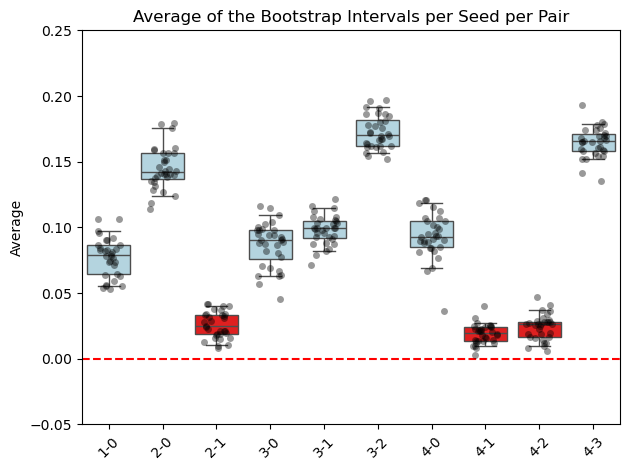

In [18]:
# for each seed plot boxplot of differences around orginal kld

list_average_ci = []
for seed in df_runs['tags.seed_value'].unique():
    table_original = table_original_dict[seed]

    # add vector to the 
    centered_data = pd.DataFrame(dict_diffs) + np.array(table_original[metric])
    
    average_ci = centered_data.mean(0)

    list_average_ci.append(average_ci)

df_average_ci = pd.DataFrame(list_average_ci)
# --- Boxplot with 90% interval (whis=[5, 95]) ---
sns.boxplot(data=df_average_ci, whis=[5, 95], showfliers=False, palette=['lightblue','lightblue','red','lightblue','lightblue',
                                                                             'lightblue','lightblue','red','red','lightblue'])
# Colors on independence from above
sns.stripplot(data=df_average_ci, color='black', alpha=0.4, dodge=True, jitter=0.25)

plt.ylim(-0.05,0.25)
plt.axhline(0, color='red', linestyle='--')
plt.ylabel("Average")
plt.title("Average of the Bootstrap Intervals per Seed per Pair")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()